# PWWB Data Channel Analysis Notebook

This notebook imports the `PWWBData` class and analyzes each data channel in detail. We'll visualize the data and display actual values in dataframes to understand what's in each channel, cell by cell.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
from dotenv import load_dotenv
import sys
from datetime import datetime, timedelta
import warnings

# Import the PWWBData class from the module that contains it
# Modify this import statement as needed to match your project structure
from pwwbdata import PWWBData

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables from .env file
load_dotenv()

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# Create custom colormaps for better visualization
# Blue colormap for general data
colors_blue = [(0.95, 0.95, 0.95), (0.8, 0.8, 1), (0, 0, 0.8)]  # White (0) -> Light blue -> Dark blue
cmap_blue = LinearSegmentedColormap.from_list("custom_blue", colors_blue)

# Red colormap for temperature data
colors_red = [(0.95, 0.95, 0.95), (1, 0.8, 0.8), (0.8, 0, 0)]  # White (0) -> Light red -> Dark red
cmap_red = LinearSegmentedColormap.from_list("custom_red", colors_red)

# Green colormap for AOD data
colors_green = [(0.95, 0.95, 0.95), (0.8, 1, 0.8), (0, 0.5, 0)]  # White (0) -> Light green -> Dark green
cmap_green = LinearSegmentedColormap.from_list("custom_green", colors_green)

print("Setup complete!")

Setup complete!


## Initialize PWWB Data

First, we'll initialize the PWWBData class with a small date range to keep computation time reasonable. Adjust the parameters as needed.

In [2]:
# Check if EARTHDATA_TOKEN is available
token = os.getenv("EARTHDATA_TOKEN")
print(f"EARTHDATA_TOKEN available: {token is not None}")

# Initialize with a small date range (2 days) for testing
# Adjust these parameters as needed
start_date = "2024-12-01"  # Replace with a date range that makes sense for your data
end_date = "2024-12-02"    # Using just 2 days to keep processing time reasonable
dim = 200                   # Spatial dimension (50x50 grid)

# Create a data directory if it doesn't exist
os.makedirs("data/pwwb_cache", exist_ok=True)

# Initialize PWWBData
# Set use_cached_data=True to use cached data if available
data = PWWBData(
    start_date=start_date, 
    end_date=end_date,
    dim=dim,
    verbose=True,          # Set to True to see processing details
    use_cached_data=True   # Use cached data if available
)

print(f"\nData initialization complete!")
print(f"Dataset shape: {data.data.shape}")

EARTHDATA_TOKEN available: True
Initialized PWWBData with 25 hourly timestamps
Date range: 2024-12-01 00:00:00 to 2024-12-02 00:00:00
Processing remote-sensing satellite imagery...
Loading cached MAIAC AOD data from data/pwwb_cache/maiac_aod_data.npy
Fetching TROPOMI data for 2 unique dates
Processing TROPOMI data for date: 2024-12-01
Successfully processed NO2 data
Successfully processed CH4 data
Successfully processed CO data
Processing TROPOMI data for date: 2024-12-02
Successfully processed NO2 data
Successfully processed CH4 data
Successfully processed CO data
Created TROPOMI data with shape (25, 200, 200, 3)
Processing wildfire/smoke data...
Loading cached MODIS fire data from data/pwwb_cache/modis_fire_data.npy
Fetching MERRA-2 data for 25 timestamps
Processing MERRA-2 data for day: 2024-12-01
Trying CMR API method...
CMR API error: 401
Trying direct MERRA-2 API method...
Error with direct MERRA-2 API method: HTTPSConnectionPool(host='api.earthdata.nasa.gov', port=443): Max retr

## Helper Functions for Data Analysis

These functions will help us analyze and visualize the data.

In [3]:
def create_readable_df(data_array, timestamp_idx=0, frame_idx=0, channel_idx=0, sample_size=10):
    """
    Convert a spatial grid to a readable DataFrame with coordinates.
    
    Parameters:
    -----------
    data_array : numpy.ndarray
        Full data array
    timestamp_idx : int, optional
        Index of the timestamp/sample to display
    frame_idx : int, optional
        Index of the frame within the sample to display
    channel_idx : int, optional
        Index of the channel to display
    sample_size : int, optional
        Size of the center sample to extract (default: 10x10)
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with row/col indices and values
    """
    # Extract the spatial grid for the specified timestamp, frame, and channel
    spatial_grid = data_array[timestamp_idx, frame_idx, :, :, channel_idx]
    
    # Get the center of the grid
    center_row = spatial_grid.shape[0] // 2
    center_col = spatial_grid.shape[1] // 2
    
    # Extract a sample around the center
    half_size = sample_size // 2
    start_row = max(0, center_row - half_size)
    end_row = min(spatial_grid.shape[0], center_row + half_size)
    start_col = max(0, center_col - half_size)
    end_col = min(spatial_grid.shape[1], center_col + half_size)
    
    # Create DataFrame from the center sample
    sample_grid = spatial_grid[start_row:end_row, start_col:end_col]
    df = pd.DataFrame(sample_grid)
    
    # Update row and column indices to match the original grid
    df.index = range(start_row, end_row)
    df.columns = range(start_col, end_col)
    
    # Add coordinate labels
    df.index.name = 'Row'
    df.columns.name = 'Column'
    
    return df

def analyze_channel(data, channel_idx, channel_name, colormap=cmap_blue, timestep=0, frame=0):
    """
    Analyze and visualize a single channel.
    
    Parameters:
    -----------
    data : PWWBData object
        The data object
    channel_idx : int
        Index of the channel to analyze
    channel_name : str
        Name of the channel
    colormap : matplotlib.colors.LinearSegmentedColormap, optional
        Colormap to use for visualization
    timestep : int, optional
        Index of the timestep to analyze
    frame : int, optional
        Index of the frame to analyze
    """
    # Get the data for this channel
    channel_data = data.data[timestep, frame, :, :, channel_idx]
    
    # Print basic statistics
    print(f"\n### Channel {channel_idx}: {channel_name} ###")
    print(f"Min: {np.min(channel_data):.4f}")
    print(f"Max: {np.max(channel_data):.4f}")
    print(f"Mean: {np.mean(channel_data):.4f}")
    print(f"Std: {np.std(channel_data):.4f}")
    
    # Count non-zero values
    non_zero = np.count_nonzero(channel_data)
    total = channel_data.size
    print(f"Data coverage: {non_zero/total*100:.2f}% ({non_zero}/{total} non-zero pixels)")
    
    # Create dataframe for center sample
    df = create_readable_df(data.data, timestamp_idx=timestep, frame_idx=frame, channel_idx=channel_idx)
    
    # Create figure with 2 subplots: heatmap and dataframe
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot heatmap
    im = ax1.imshow(channel_data, cmap=colormap, interpolation='none')
    ax1.set_title(f"{channel_name} - Full Grid")
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Value')
    
    # Display the center sample values as a table
    cell_text = [[f"{val:.2f}" for val in row] for row in df.values]
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=cell_text, 
                       rowLabels=df.index, 
                       colLabels=df.columns,
                       loc='center')
    
    # Set table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    
    ax2.set_title(f"{channel_name} - Center Sample Values")
    
    plt.tight_layout()
    plt.show()
    
    # Also display the DataFrame for more detailed inspection
    print("\nCenter sample data:")
    return df

## Get Channel Information

Let's retrieve the channel information and analyze the data structure.

In [4]:
# Get channel information
channel_info = data.get_channel_info()

# Print overall data structure
print("Data Structure:")
print(f"Number of samples: {data.data.shape[0]}")
print(f"Frames per sample: {data.data.shape[1]}")
print(f"Spatial dimensions: {data.data.shape[2]}x{data.data.shape[3]}")
print(f"Number of channels: {data.data.shape[4]}")
print("\nChannel Groups:")
print(f"MAIAC AOD channels: {len(channel_info['maiac_channels'])}")
print(f"TROPOMI channels: {len(channel_info['tropomi_channels'])}")
print(f"MODIS Fire channels: {len(channel_info['modis_fire_channels'])}")
print(f"MERRA-2 channels: {len(channel_info['merra2_channels'])}")
print(f"METAR channels: {len(channel_info['metar_channels'])}")

# Create a DataFrame with channel information
channel_df = pd.DataFrame({
    'Channel Index': range(len(channel_info['channel_names'])),
    'Channel Name': channel_info['channel_names'],
    'Channel Group': [
        'MAIAC AOD' if name in channel_info['maiac_channels'] else
        'TROPOMI' if name in channel_info['tropomi_channels'] else
        'MODIS Fire' if name in channel_info['modis_fire_channels'] else
        'MERRA-2' if name in channel_info['merra2_channels'] else
        'METAR' if name in channel_info['metar_channels'] else
        'Unknown'
        for name in channel_info['channel_names']
    ]
})

channel_df

Data Structure:
Number of samples: 2
Frames per sample: 24
Spatial dimensions: 200x200
Number of channels: 17

Channel Groups:
MAIAC AOD channels: 1
TROPOMI channels: 3
MODIS Fire channels: 1
MERRA-2 channels: 3
METAR channels: 9


,Channel Index,Channel Name,Channel Group
0,0,MAIAC_AOD,MAIAC AOD
1,1,TROPOMI_Methane,TROPOMI
2,2,TROPOMI_NO2,TROPOMI
3,3,TROPOMI_CO,TROPOMI
4,4,MODIS_FRP,MODIS Fire
5,5,MERRA2_PBL_Height,MERRA-2
6,6,MERRA2_Surface_Air_Temp,MERRA-2
7,7,MERRA2_Surface_Exchange_Coef,MERRA-2
8,8,METAR_Wind_Speed,METAR
9,9,METAR_Wind_Direction,METAR


## Analyze MAIAC AOD Data

First, let's examine the MAIAC AOD (Aerosol Optical Depth) data.


### Channel 0: MAIAC_AOD ###
Min: -28672.0000
Max: -11408.2182
Mean: -22674.3335
Std: 5129.6428
Data coverage: 100.00% (40000/40000 non-zero pixels)


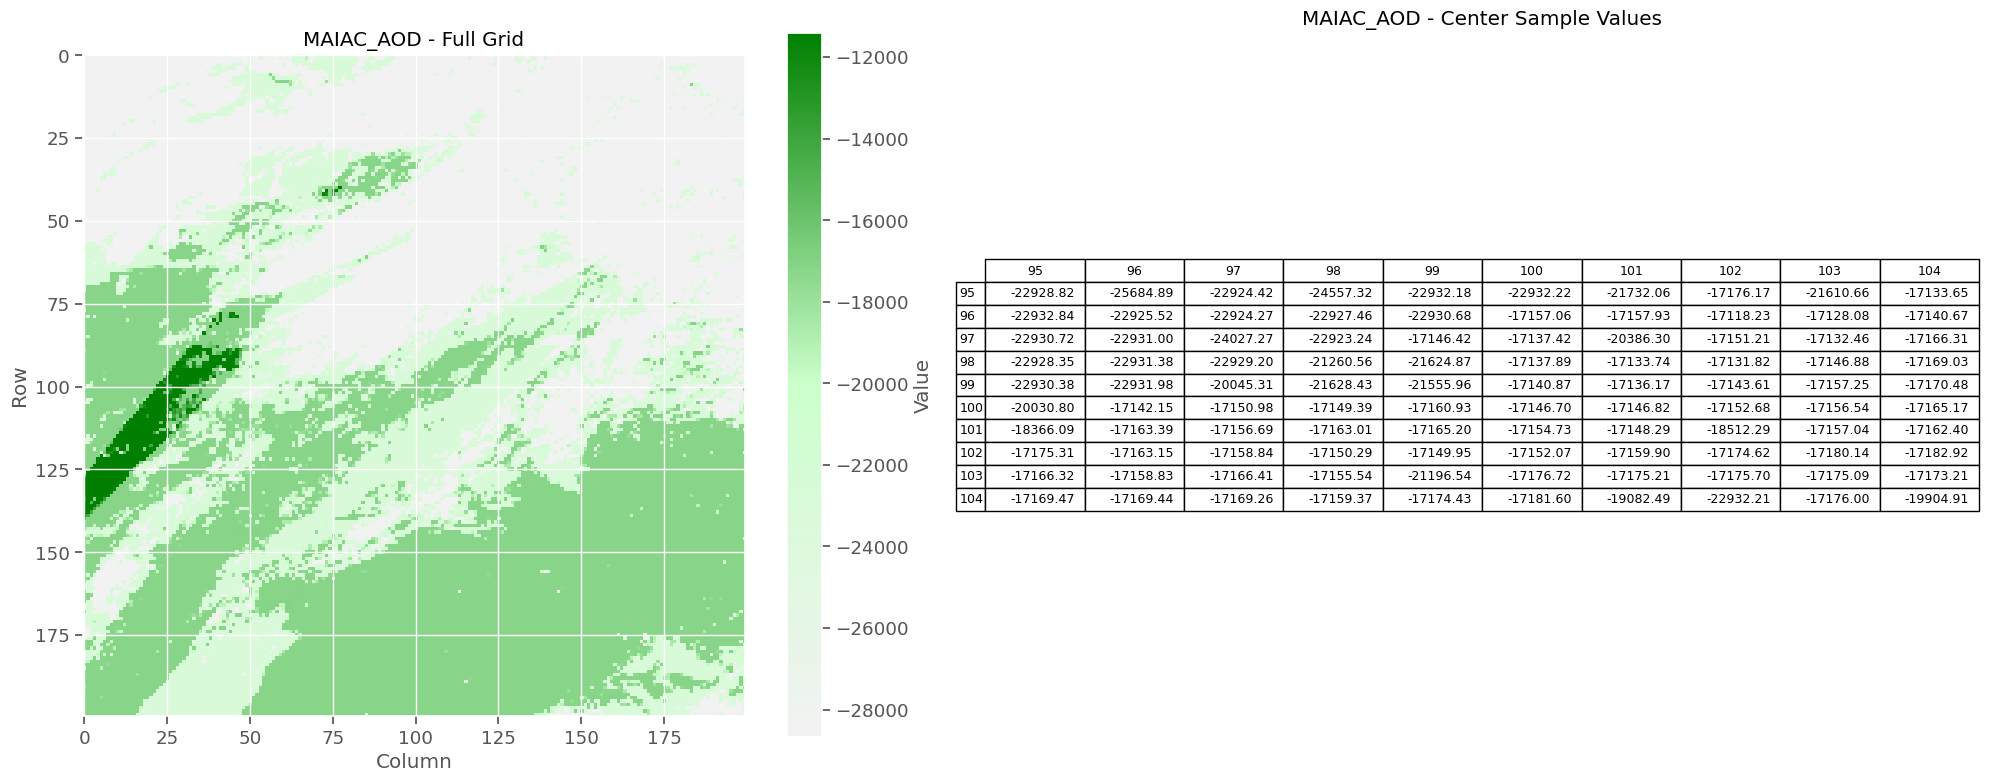


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,-22928.823914,-25684.889695,-22924.420101,-24557.320113,-22932.182379,-22932.222646,-21732.059347,-17176.165481,-21610.655095,-17133.650282
96,-22932.837272,-22925.520022,-22924.271811,-22927.464963,-22930.682412,-17157.055185,-17157.932219,-17118.227701,-17128.084947,-17140.669534
97,-22930.717239,-22930.995278,-24027.266301,-22923.243893,-17146.421222,-17137.422227,-20386.301391,-17151.213227,-17132.464392,-17166.306523
98,-22928.345532,-22931.376334,-22929.200000,-21260.562642,-21624.868220,-17137.889159,-17133.740365,-17131.815202,-17146.878210,-17169.026151
99,-22930.379899,-22931.976975,-20045.309664,-21628.432772,-21555.955486,-17140.867150,-17136.171859,-17143.610272,-17157.247878,-17170.475836
100,-20030.802348,-17142.150754,-17150.981500,-17149.385147,-17160.929679,-17146.702230,-17146.816419,-17152.683382,-17156.543996,-17165.173334
101,-18366.089149,-17163.386106,-17156.685659,-17163.007374,-17165.201904,-17154.727638,-17148.285962,-18512.292695,-17157.040292,-17162.397172
102,-17175.312204,-17163.151774,-17158.835671,-17150.293033,-17149.953370,-17152.074887,-17159.896366,-17174.619343,-17180.141294,-17182.919250
103,-17166.319972,-17158.826555,-17166.412293,-17155.535587,-21196.536481,-17176.715699,-17175.213065,-17175.701508,-17175.090720,-17173.208959


In [5]:
# Get indices for MAIAC AOD channels
maiac_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['maiac_channels']]

# Analyze each MAIAC AOD channel
for i, idx in enumerate(maiac_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_green)
    display(df)

## Analyze TROPOMI Data

Next, let's examine the TROPOMI data (methane, nitrogen dioxide, and carbon monoxide).


### Channel 1: TROPOMI_Methane ###
Min: 1891.5227
Max: 1978.4615
Mean: 1933.5082
Std: 13.9400
Data coverage: 100.00% (40000/40000 non-zero pixels)


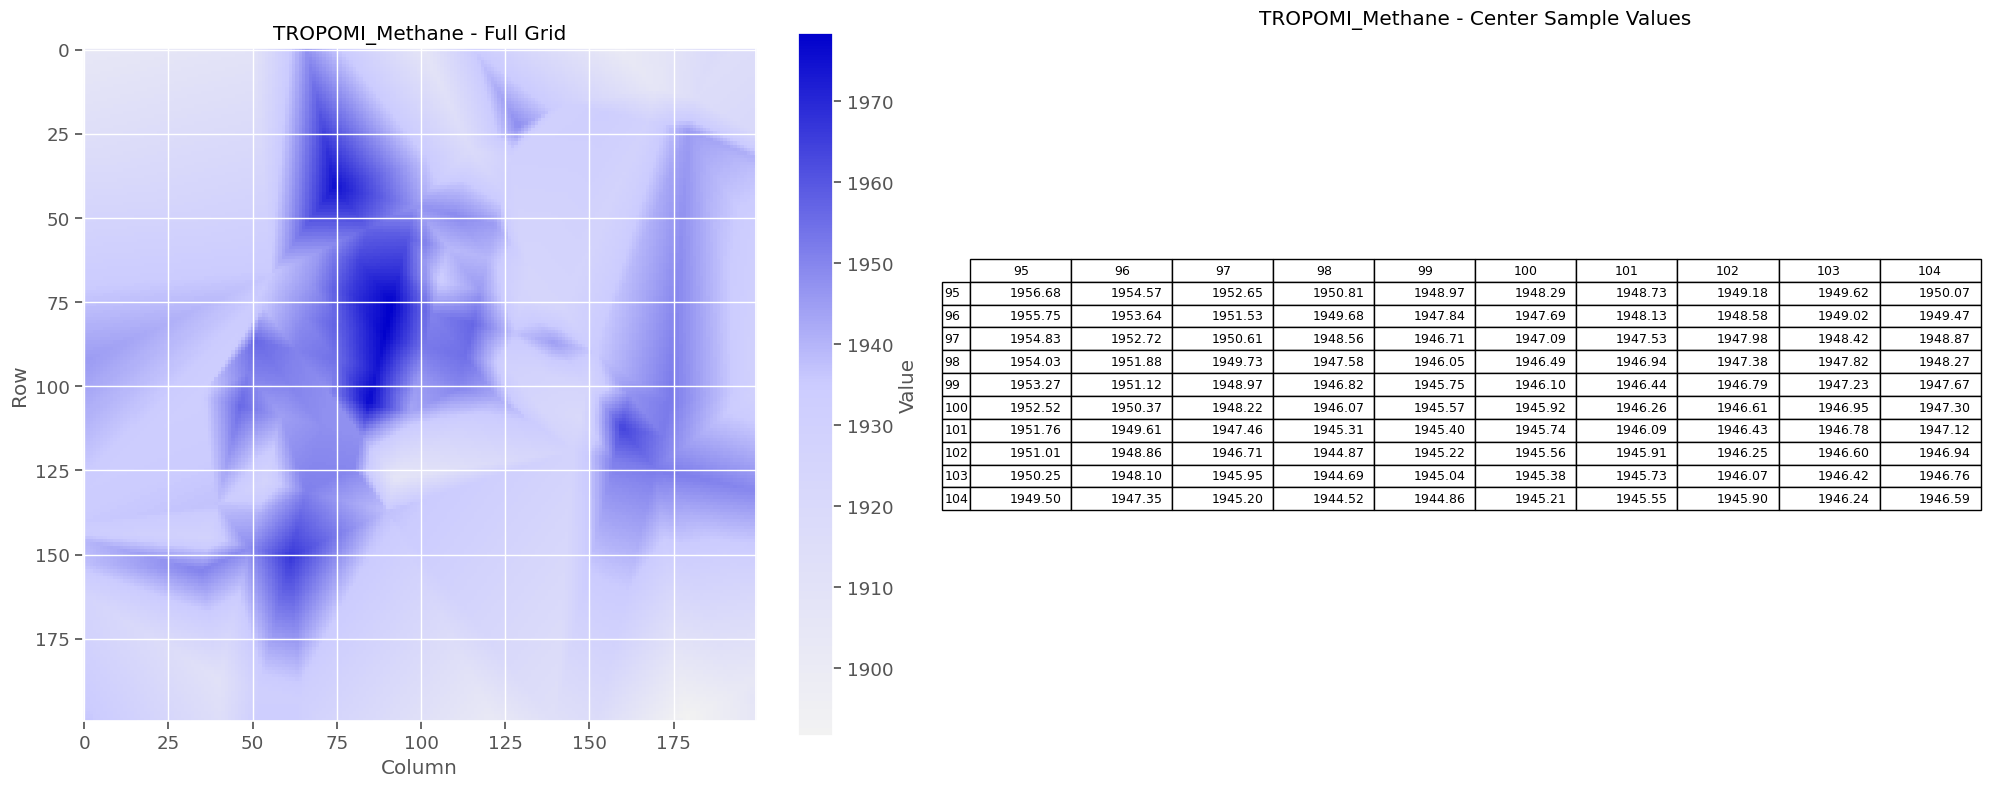


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,1956.675076,1954.565108,1952.652579,1950.811099,1948.969619,1948.288586,1948.733335,1949.178084,1949.622833,1950.067581
96,1955.754671,1953.644702,1951.534734,1949.683127,1947.841647,1947.689158,1948.133907,1948.578656,1949.023405,1949.468153
97,1954.834265,1952.724297,1950.614329,1948.555156,1946.713675,1947.089730,1947.534479,1947.979228,1948.423977,1948.868725
98,1954.027015,1951.877430,1949.727846,1947.583955,1946.045553,1946.490302,1946.935051,1947.379800,1947.824549,1948.269297
99,1953.271905,1951.122321,1948.972737,1946.823152,1945.752206,1946.097111,1946.442016,1946.786921,1947.225121,1947.669869
100,1952.516796,1950.367212,1948.217627,1946.068043,1945.574053,1945.918958,1946.263863,1946.608768,1946.953673,1947.298578
101,1951.761687,1949.612102,1947.462518,1945.312934,1945.395900,1945.740805,1946.085710,1946.430615,1946.775520,1947.120425
102,1951.006577,1948.856993,1946.707409,1944.872842,1945.217747,1945.562652,1945.907557,1946.252462,1946.597367,1946.942272
103,1950.251468,1948.101884,1945.952299,1944.694689,1945.039594,1945.384499,1945.729404,1946.074309,1946.419214,1946.764119



### Channel 2: TROPOMI_NO2 ###
Min: 0.0000
Max: 0.0005
Mean: 0.0001
Std: 0.0001
Data coverage: 100.00% (40000/40000 non-zero pixels)


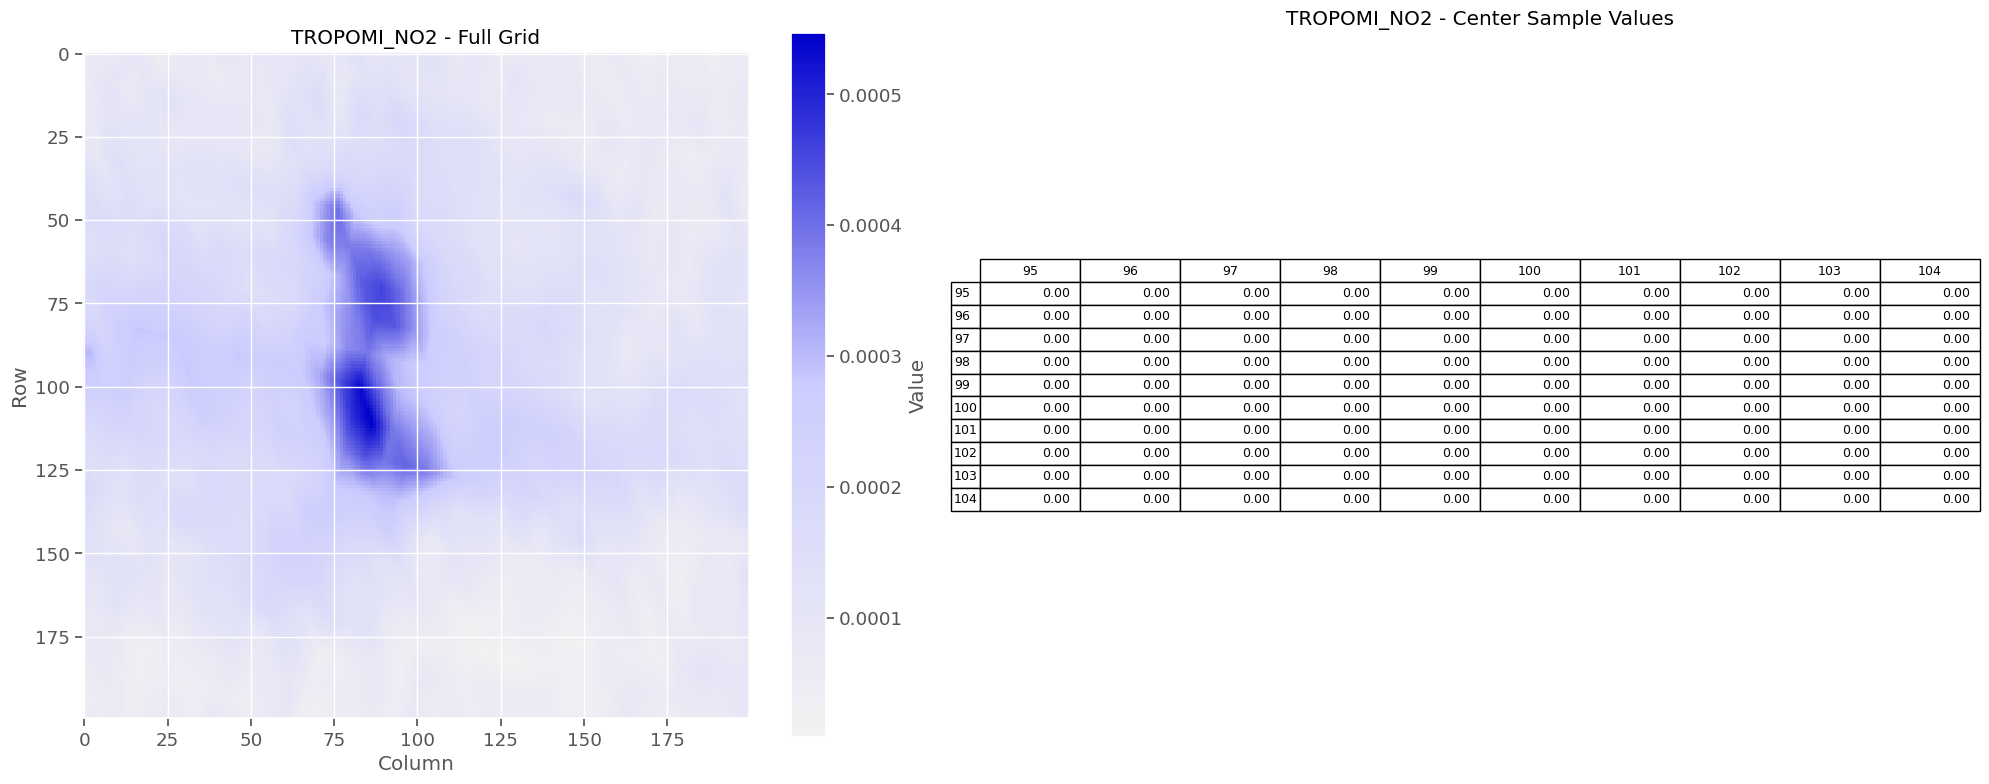


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.000296,0.000290,0.000285,0.000282,0.000279,0.000275,0.000272,0.000269,0.000265,0.000261
96,0.000296,0.000290,0.000286,0.000283,0.000280,0.000276,0.000273,0.000270,0.000265,0.000259
97,0.000297,0.000291,0.000287,0.000284,0.000280,0.000277,0.000274,0.000271,0.000264,0.000257
98,0.000297,0.000292,0.000288,0.000285,0.000281,0.000278,0.000275,0.000271,0.000264,0.000256
99,0.000298,0.000293,0.000289,0.000286,0.000282,0.000279,0.000276,0.000272,0.000264,0.000256
100,0.000298,0.000294,0.000290,0.000287,0.000283,0.000280,0.000276,0.000271,0.000264,0.000256
101,0.000299,0.000295,0.000291,0.000288,0.000284,0.000280,0.000277,0.000271,0.000263,0.000256
102,0.000300,0.000296,0.000292,0.000289,0.000285,0.000281,0.000278,0.000271,0.000263,0.000255
103,0.000302,0.000297,0.000293,0.000290,0.000286,0.000282,0.000279,0.000271,0.000263,0.000255



### Channel 3: TROPOMI_CO ###
Min: 0.0192
Max: 0.0407
Mean: 0.0315
Std: 0.0040
Data coverage: 100.00% (40000/40000 non-zero pixels)


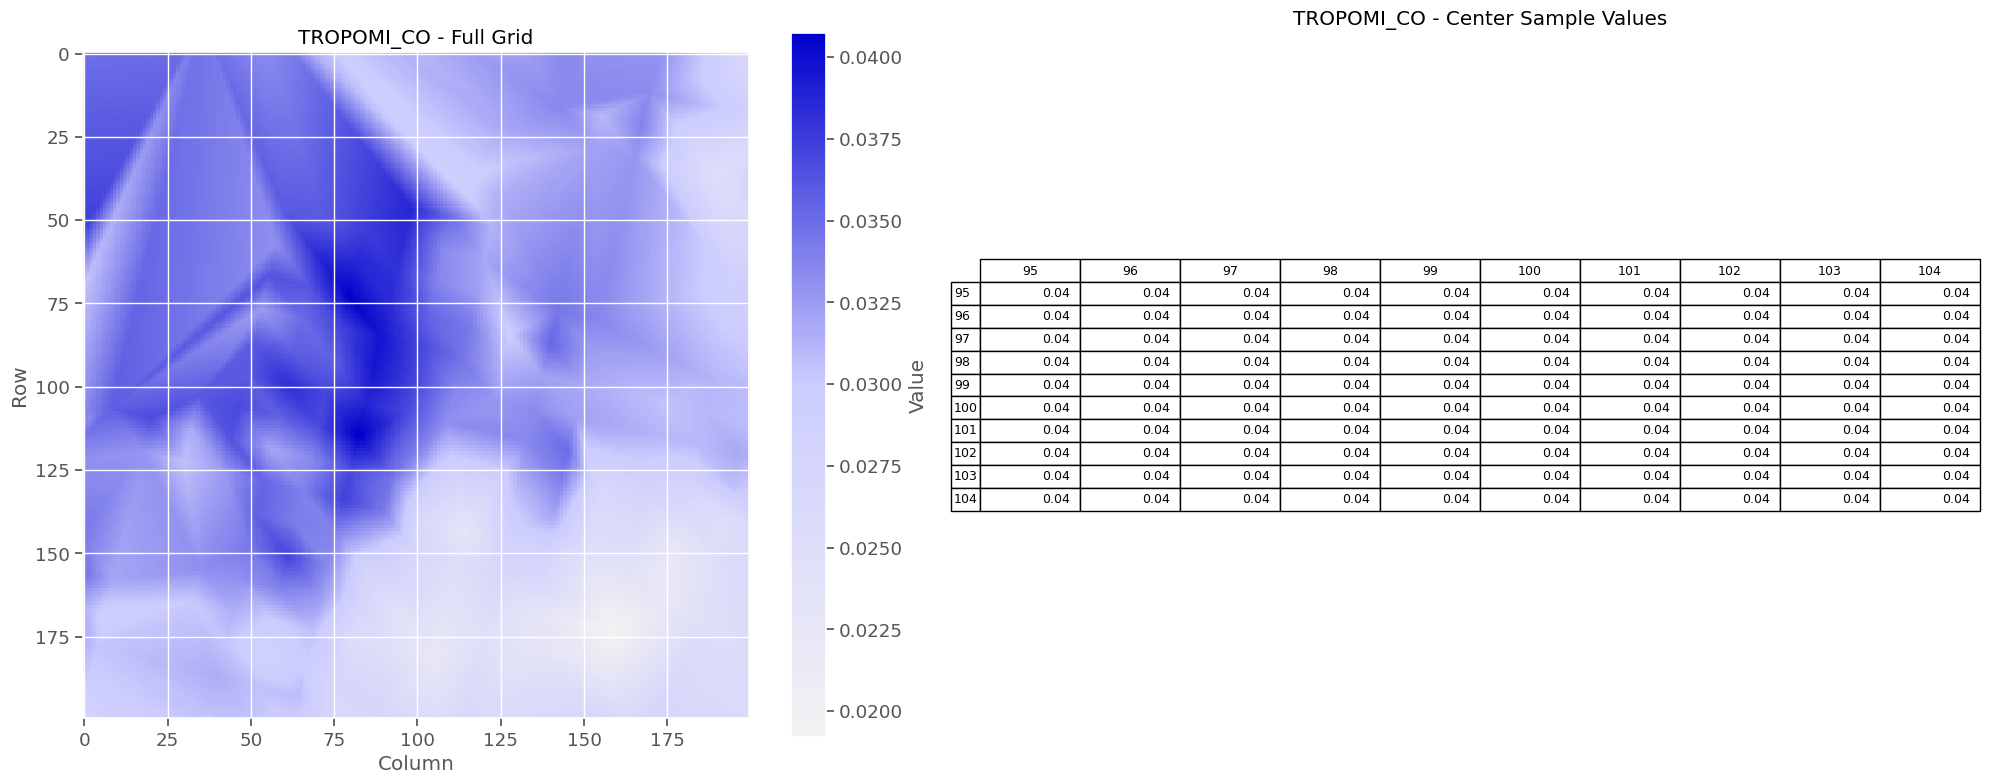


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.038062,0.037877,0.037665,0.037444,0.037222,0.036972,0.036693,0.036415,0.036136,0.035858
96,0.038009,0.037824,0.037638,0.037418,0.037197,0.036933,0.036655,0.036376,0.036098,0.035820
97,0.037955,0.037770,0.037585,0.037393,0.037171,0.036895,0.036616,0.036338,0.036059,0.035781
98,0.037887,0.037707,0.037527,0.037346,0.037134,0.036856,0.036578,0.036299,0.036021,0.035742
99,0.037812,0.037632,0.037452,0.037272,0.037047,0.036779,0.036519,0.036259,0.035982,0.035704
100,0.037737,0.037557,0.037377,0.037197,0.036948,0.036665,0.036402,0.036142,0.035883,0.035623
101,0.037661,0.037481,0.037301,0.037121,0.036849,0.036566,0.036285,0.036025,0.035766,0.035506
102,0.037586,0.037406,0.037226,0.037033,0.036750,0.036467,0.036184,0.035908,0.035649,0.035389
103,0.037511,0.037331,0.037151,0.036934,0.036651,0.036368,0.036085,0.035802,0.035532,0.035272


In [6]:
# Get indices for TROPOMI channels
tropomi_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                  if name in channel_info['tropomi_channels']]

# Analyze each TROPOMI channel
for i, idx in enumerate(tropomi_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name)
    display(df)

## Analyze MODIS Fire Data

Now, let's examine the MODIS Fire Radiative Power (FRP) data.


### Channel 4: MODIS_FRP ###
Min: 0.0000
Max: 0.5421
Mean: 0.1710
Std: 0.1862
Data coverage: 78.08% (31230/40000 non-zero pixels)


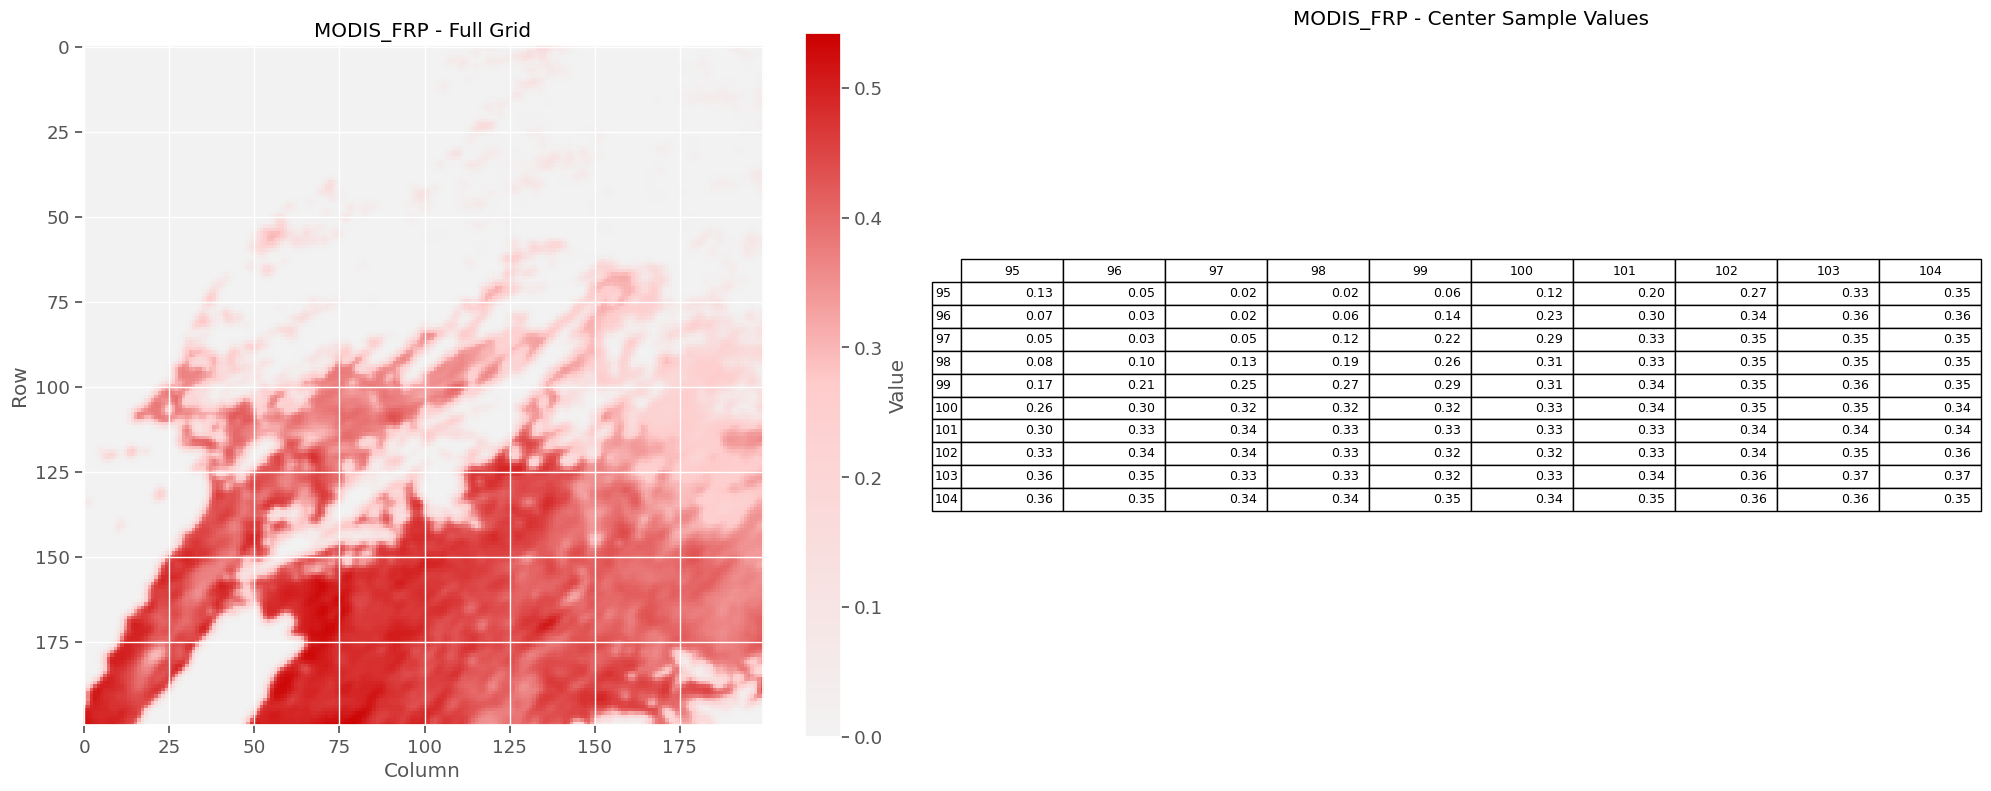


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.127271,0.054223,0.016315,0.019134,0.056278,0.120730,0.197687,0.270798,0.325254,0.351777
96,0.071525,0.025189,0.017336,0.055557,0.138722,0.230830,0.298795,0.339164,0.355364,0.356124
97,0.050511,0.031996,0.049827,0.118034,0.217725,0.294512,0.334489,0.350334,0.352398,0.350134
98,0.079435,0.097823,0.133412,0.194501,0.261350,0.305512,0.333749,0.348160,0.351456,0.351641
99,0.167239,0.212167,0.245129,0.267243,0.290410,0.313788,0.337314,0.351642,0.355138,0.352052
100,0.259533,0.298891,0.315813,0.317027,0.321094,0.329644,0.340432,0.347974,0.348449,0.342320
101,0.301146,0.328214,0.335241,0.334710,0.334384,0.333258,0.334146,0.338217,0.341933,0.341971
102,0.333913,0.340790,0.335984,0.329964,0.324397,0.323429,0.330912,0.343564,0.354918,0.358762
103,0.355043,0.346577,0.334926,0.325864,0.320727,0.326905,0.343718,0.361849,0.369479,0.366595


In [7]:
# Get indices for MODIS Fire channels
modis_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['modis_fire_channels']]

# Analyze each MODIS Fire channel
for i, idx in enumerate(modis_indices):
    channel_name = channel_info['channel_names'][idx]
    df = analyze_channel(data, idx, channel_name, colormap=cmap_red)
    display(df)

## Analyze MERRA-2 Data

Next, let's examine the MERRA-2 data (PBL Height, Surface Air Temperature, and Surface Exchange Coefficient).


### Channel 5: MERRA2_PBL_Height ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


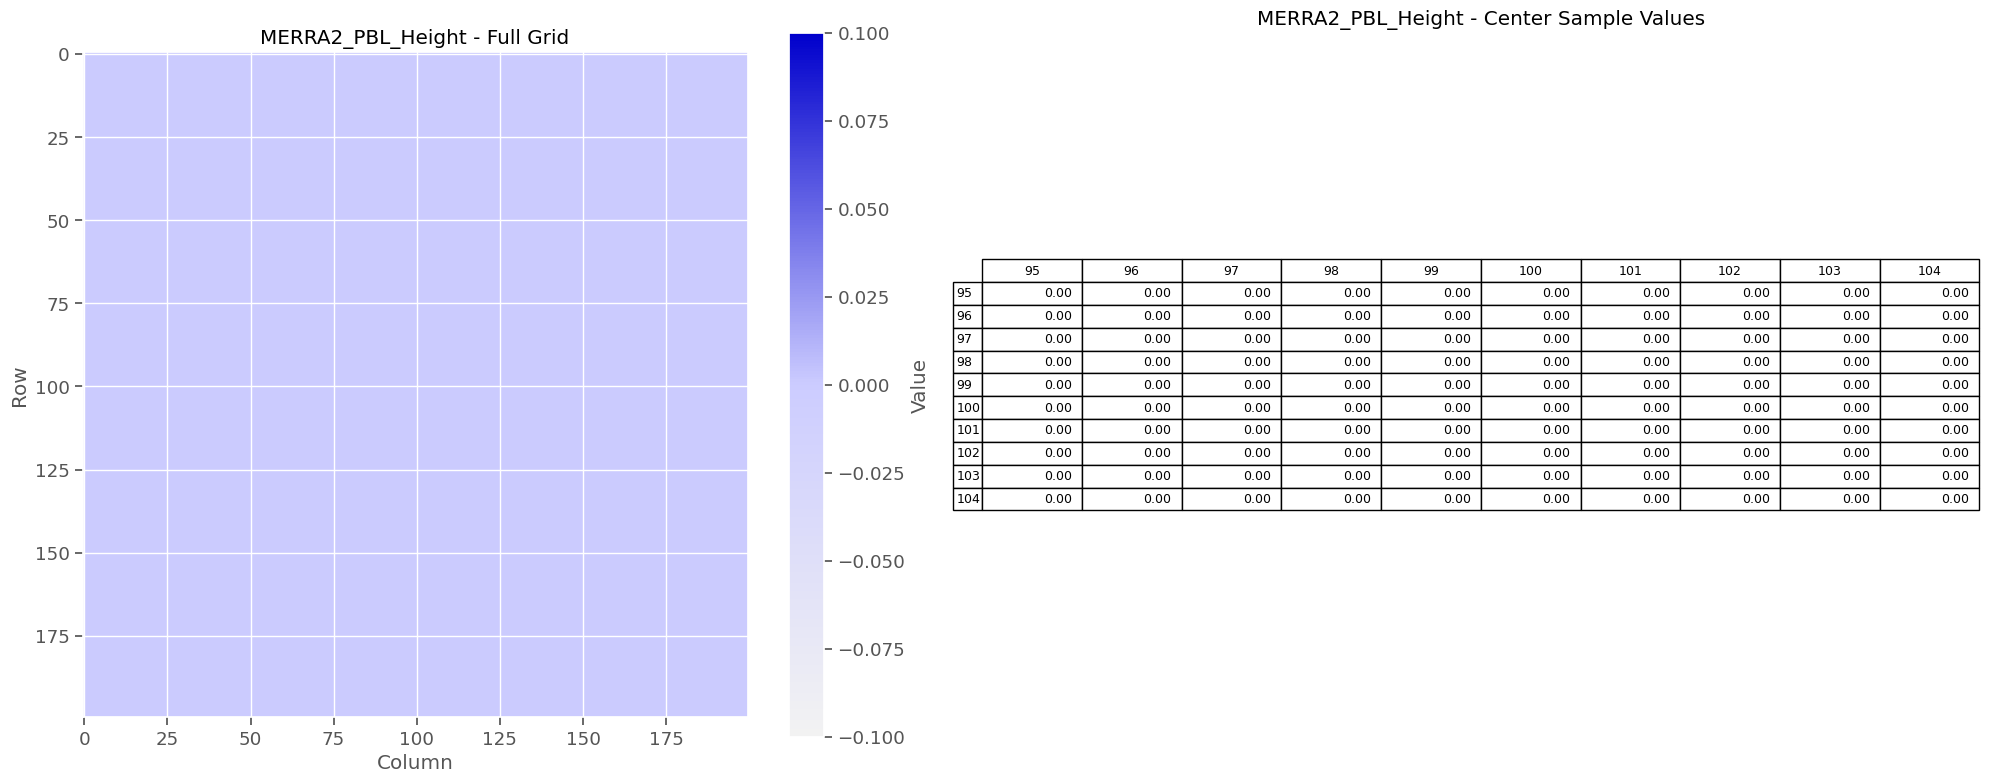


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 6: MERRA2_Surface_Air_Temp ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


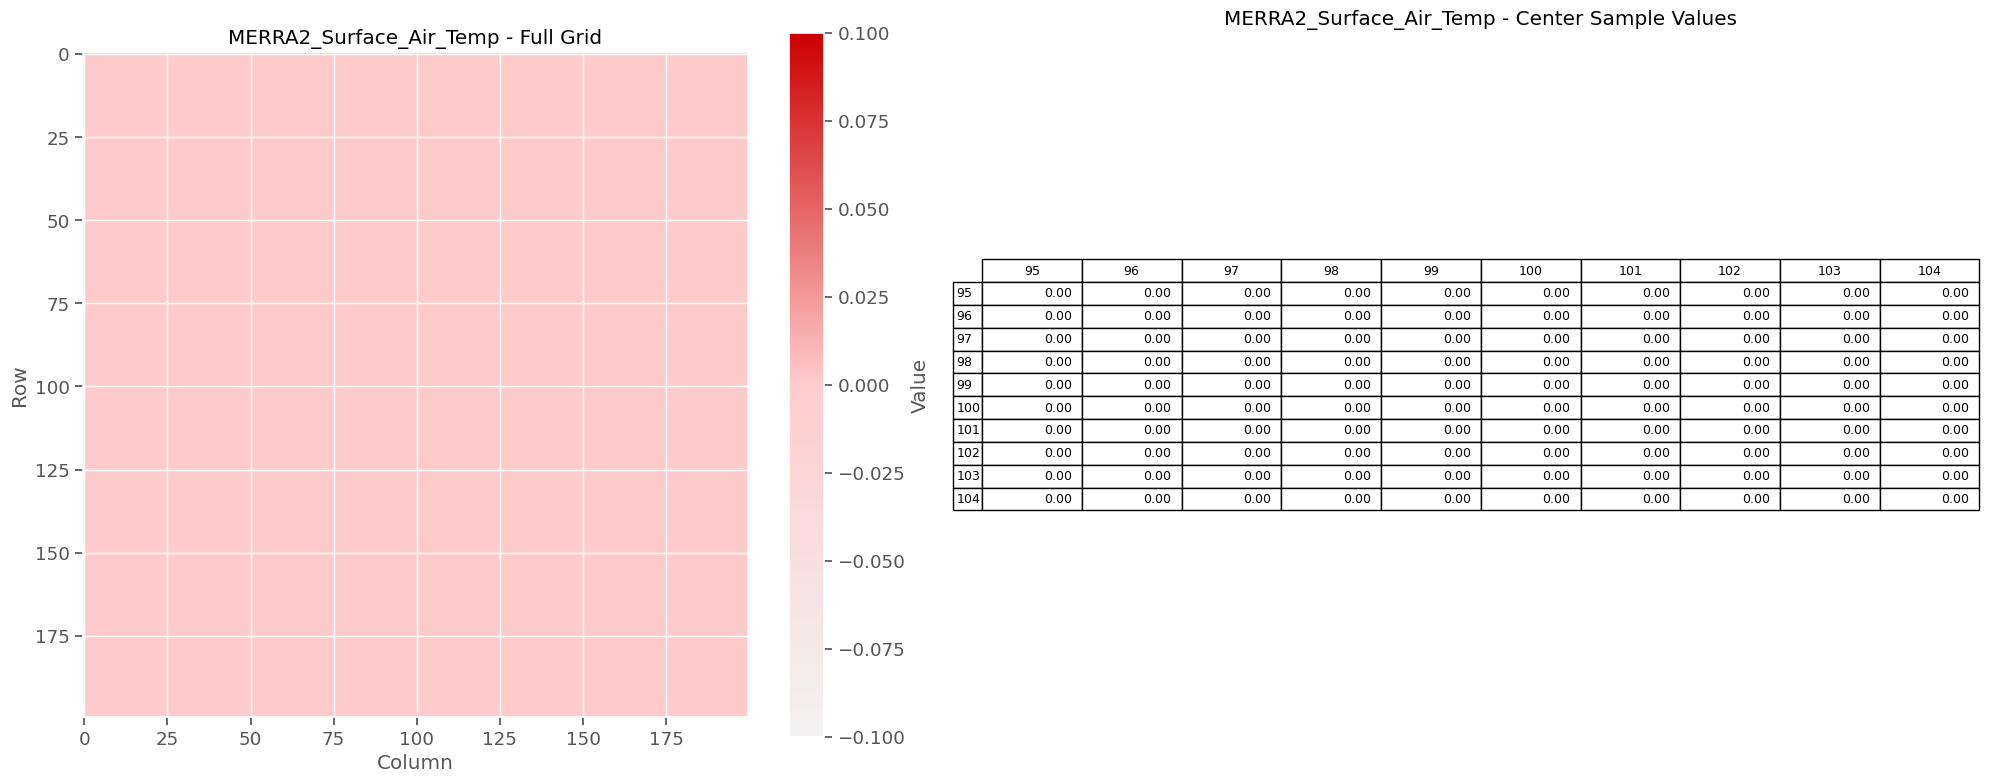


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 7: MERRA2_Surface_Exchange_Coef ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


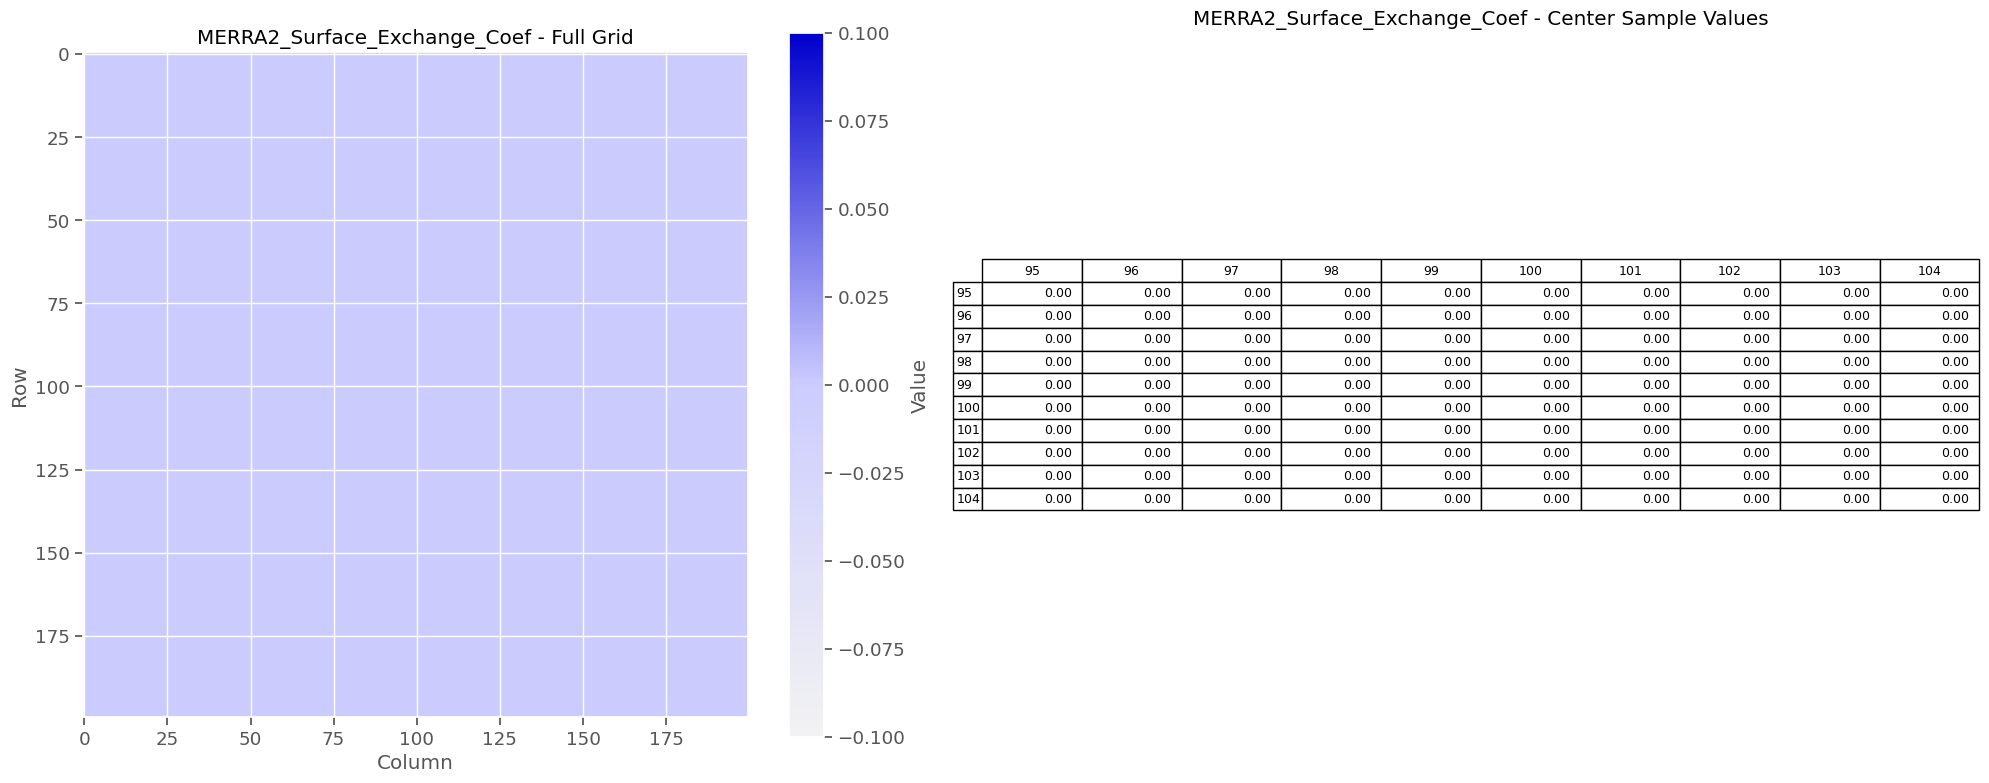


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Get indices for MERRA-2 channels
merra2_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                 if name in channel_info['merra2_channels']]

# Analyze each MERRA-2 channel
for i, idx in enumerate(merra2_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use red colormap for temperature
    if 'Temp' in channel_name:
        cmap = cmap_red
    else:
        cmap = cmap_blue
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

## Analyze METAR Meteorological Data

Finally, let's examine the METAR meteorological data.


### Channel 8: METAR_Wind_Speed ###
Min: -1.5496
Max: 14.6461
Mean: 0.7154
Std: 1.7118
Data coverage: 20.41% (8163/40000 non-zero pixels)


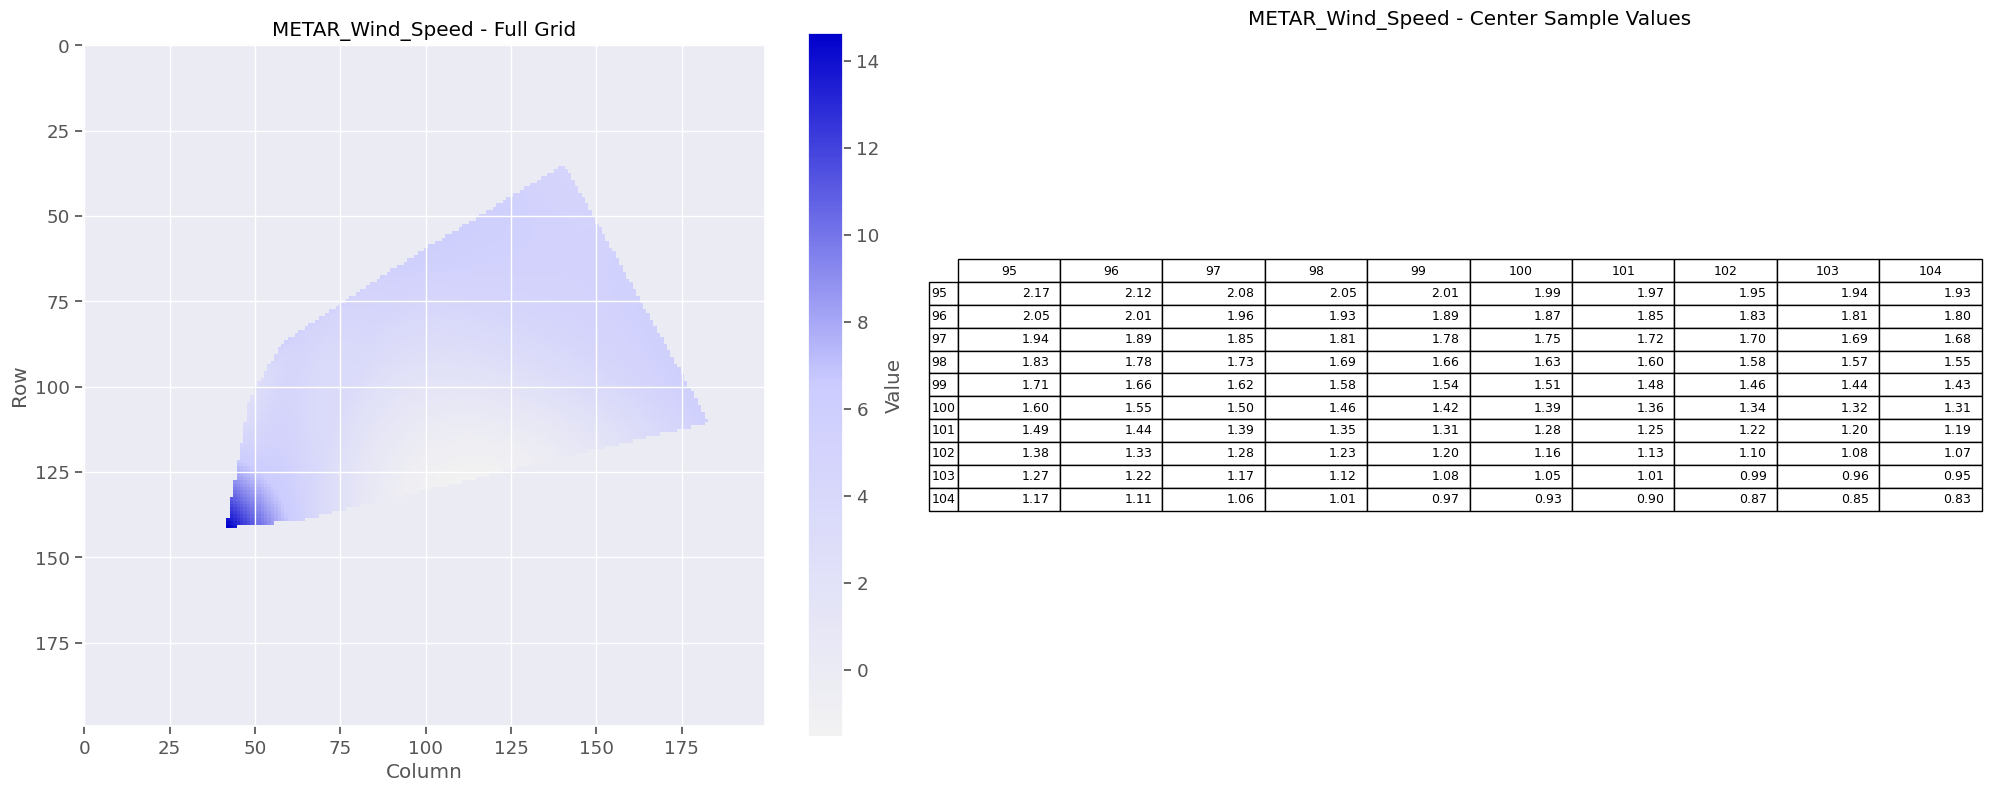


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,2.167829,2.121918,2.081117,2.045320,2.014419,1.988306,1.966874,1.950015,1.937623,1.929589
96,2.052884,2.005876,1.963960,1.927028,1.894973,1.867687,1.845064,1.826996,1.813374,1.804093
97,1.938669,1.890544,1.847492,1.809405,1.776177,1.747700,1.723866,1.704568,1.689698,1.679150
98,1.825273,1.776011,1.731804,1.692544,1.658123,1.628434,1.603369,1.582822,1.566685,1.554850
99,1.712787,1.662369,1.616987,1.576533,1.540900,1.509980,1.483666,1.461850,1.444425,1.431284
100,1.601301,1.549708,1.503131,1.461464,1.424599,1.392428,1.364844,1.341740,1.323009,1.308542
101,1.490906,1.438117,1.390327,1.347427,1.309310,1.275869,1.246997,1.222585,1.202526,1.186714
102,1.381692,1.327688,1.278665,1.234512,1.195125,1.160394,1.130212,1.104473,1.083069,1.065891
103,1.273749,1.218511,1.168234,1.122810,1.082132,1.046092,1.014582,0.987496,0.964726,0.946164



### Channel 9: METAR_Wind_Direction ###
Min: -21.7204
Max: 343.5065
Mean: 37.7704
Std: 82.4160
Data coverage: 20.41% (8163/40000 non-zero pixels)


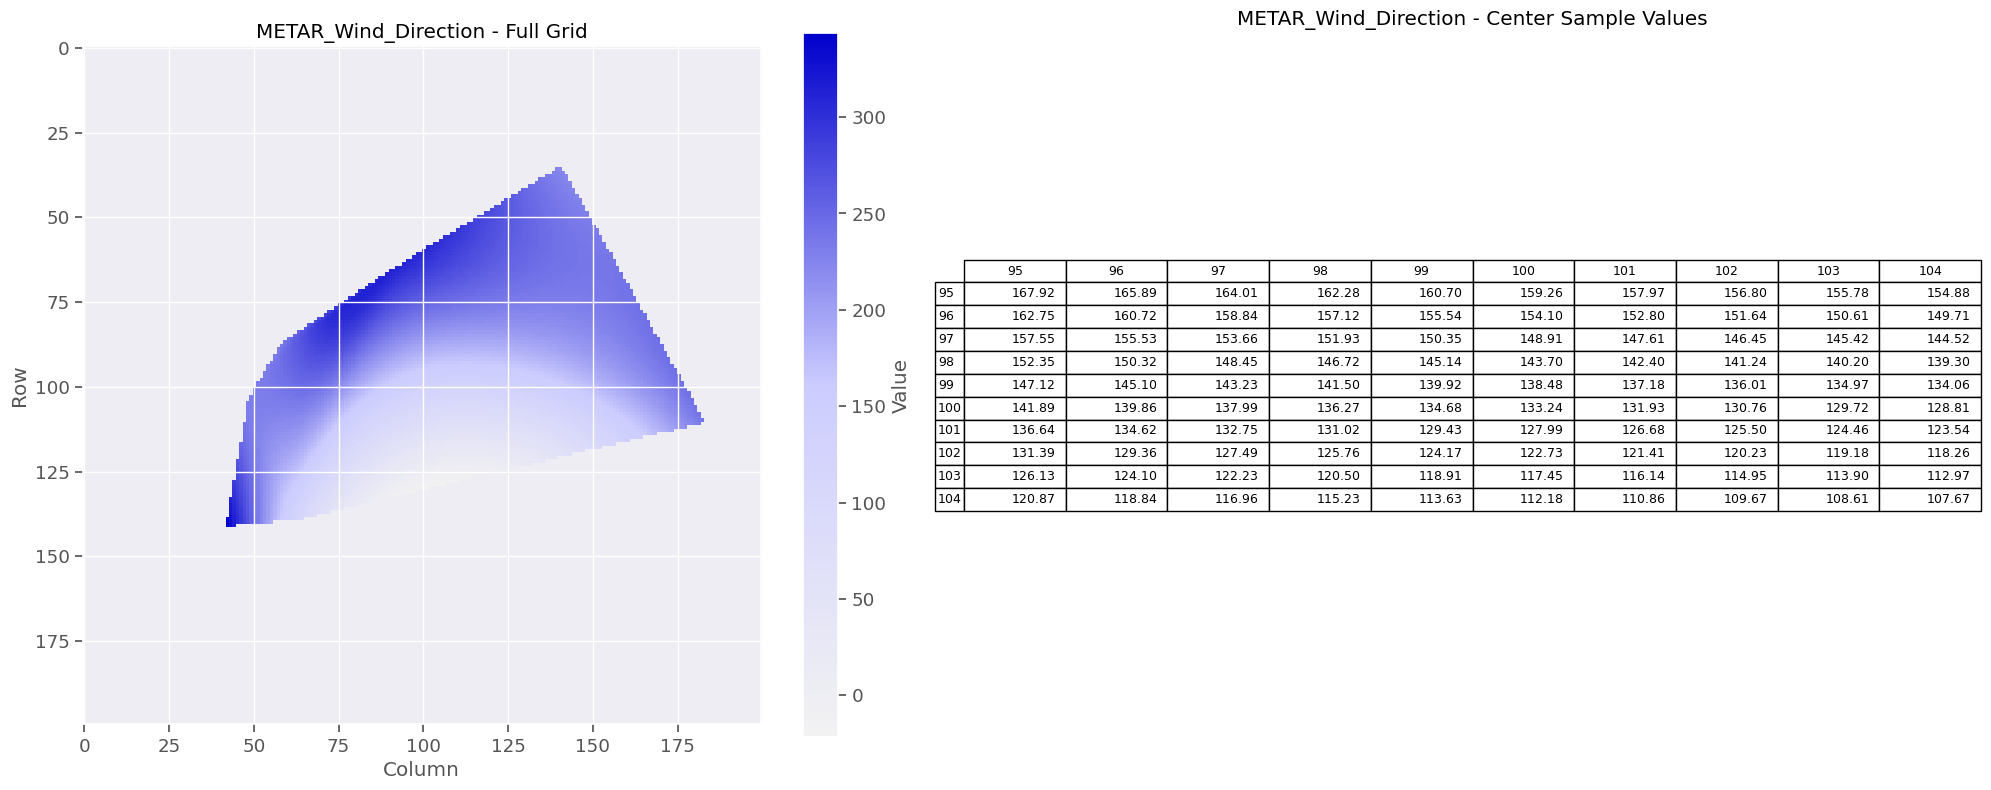


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,167.918968,165.889231,164.011883,162.283867,160.702124,159.263599,157.965232,156.803966,155.776744,154.880508
96,162.746564,160.719489,158.844207,157.117659,155.536788,154.098536,152.799845,151.637659,150.608919,149.710568
97,157.554797,155.529833,153.656063,151.930431,150.349877,148.911346,147.611780,146.448120,145.417309,144.516291
98,152.345998,150.322591,148.449781,146.724511,145.143723,143.704360,142.403365,141.237679,140.204245,139.300005
99,147.122495,145.100092,143.227689,141.502229,139.920654,138.479907,137.176929,136.008664,134.972054,134.064041
100,141.886618,139.864667,137.992118,136.265915,134.683000,133.240315,131.934803,130.763406,129.723067,128.810728
101,136.640697,134.618644,132.745397,131.017898,129.433090,127.987915,126.679315,125.504234,124.459613,123.542395
102,131.387060,129.364353,127.489855,125.760508,124.173254,122.725036,121.412796,120.233477,119.184022,118.261372
103,126.128038,124.104124,122.227822,120.496073,118.905821,117.454007,116.137574,114.953465,113.898622,112.969988



### Channel 10: METAR_Precipitation ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


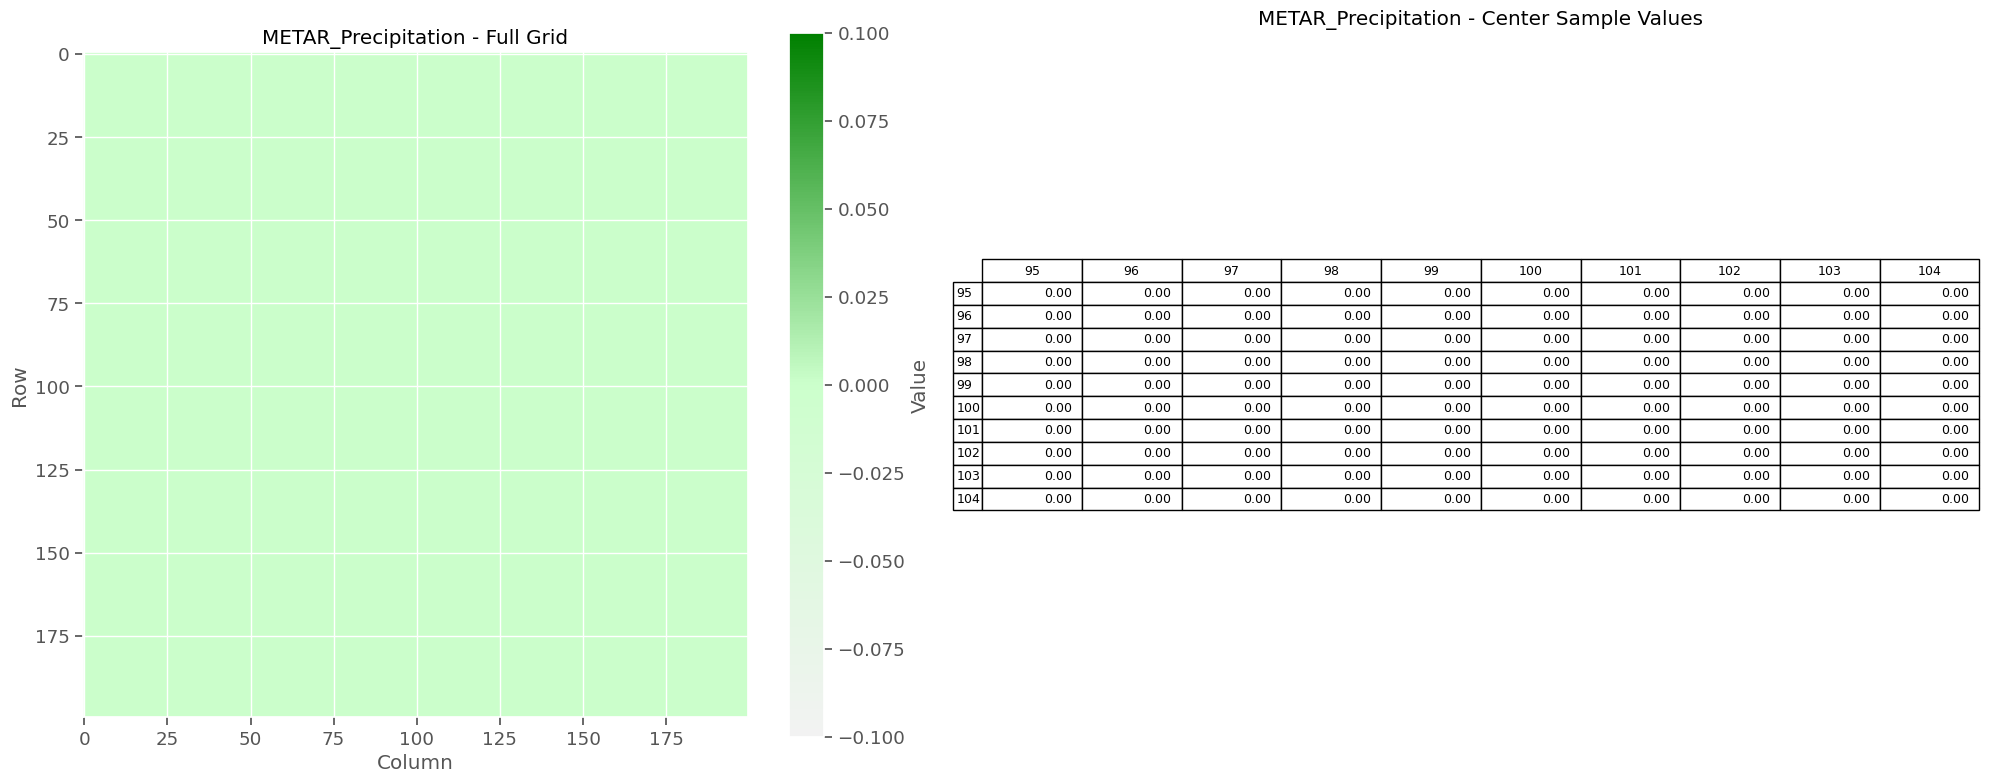


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 11: METAR_AQI ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


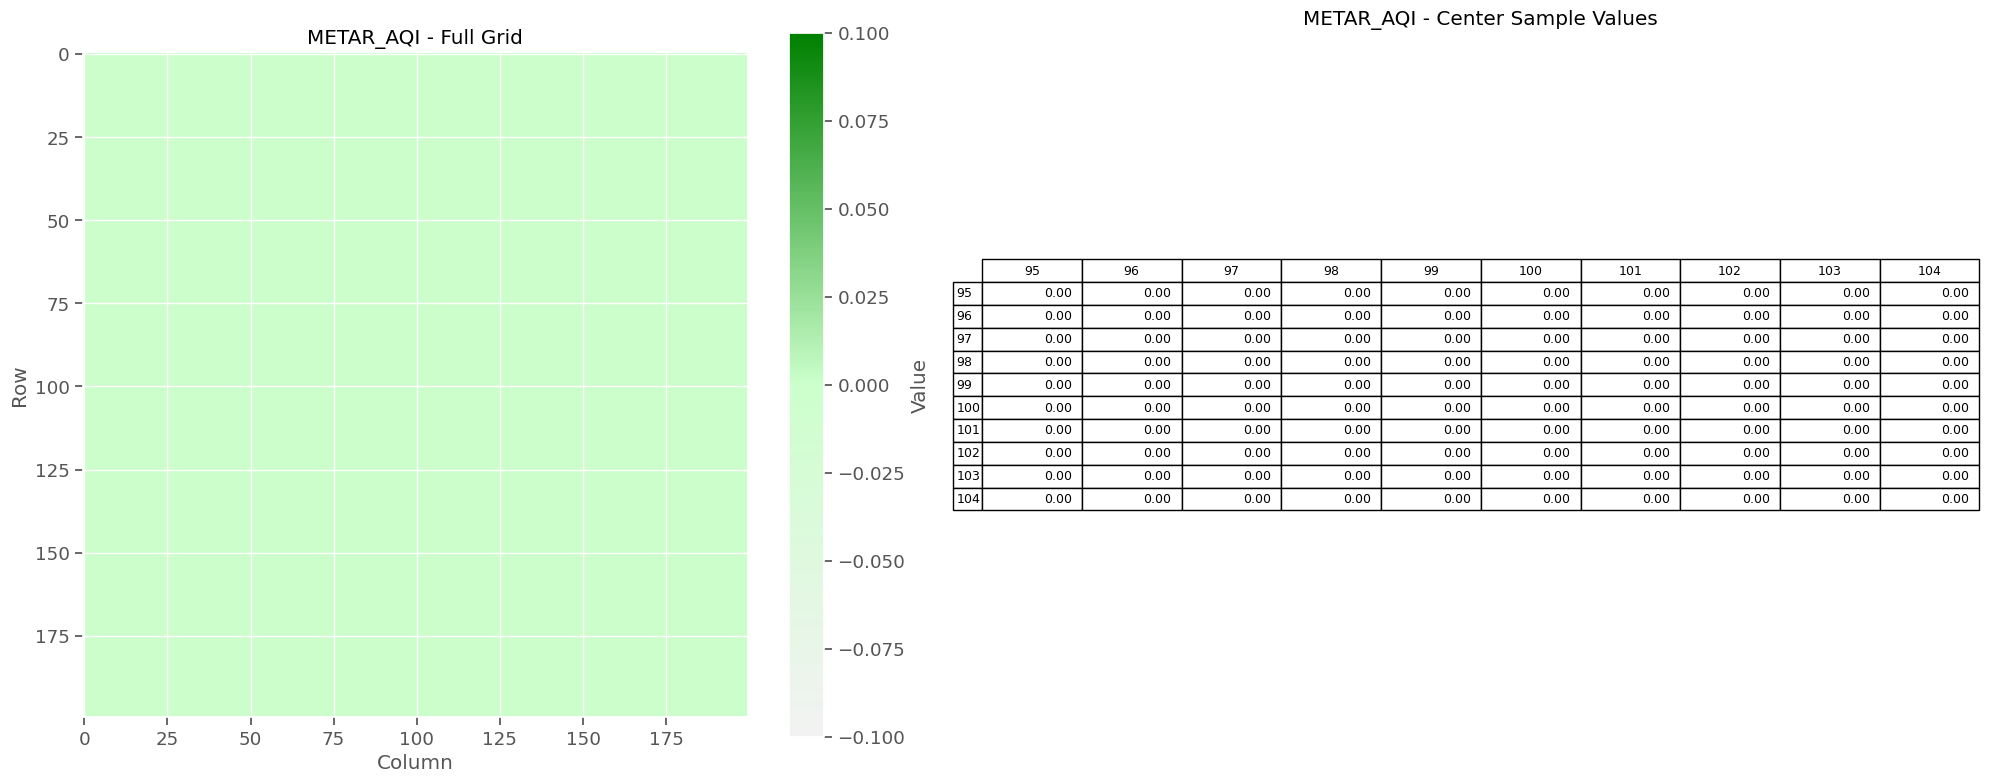


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 12: METAR_Humidity ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


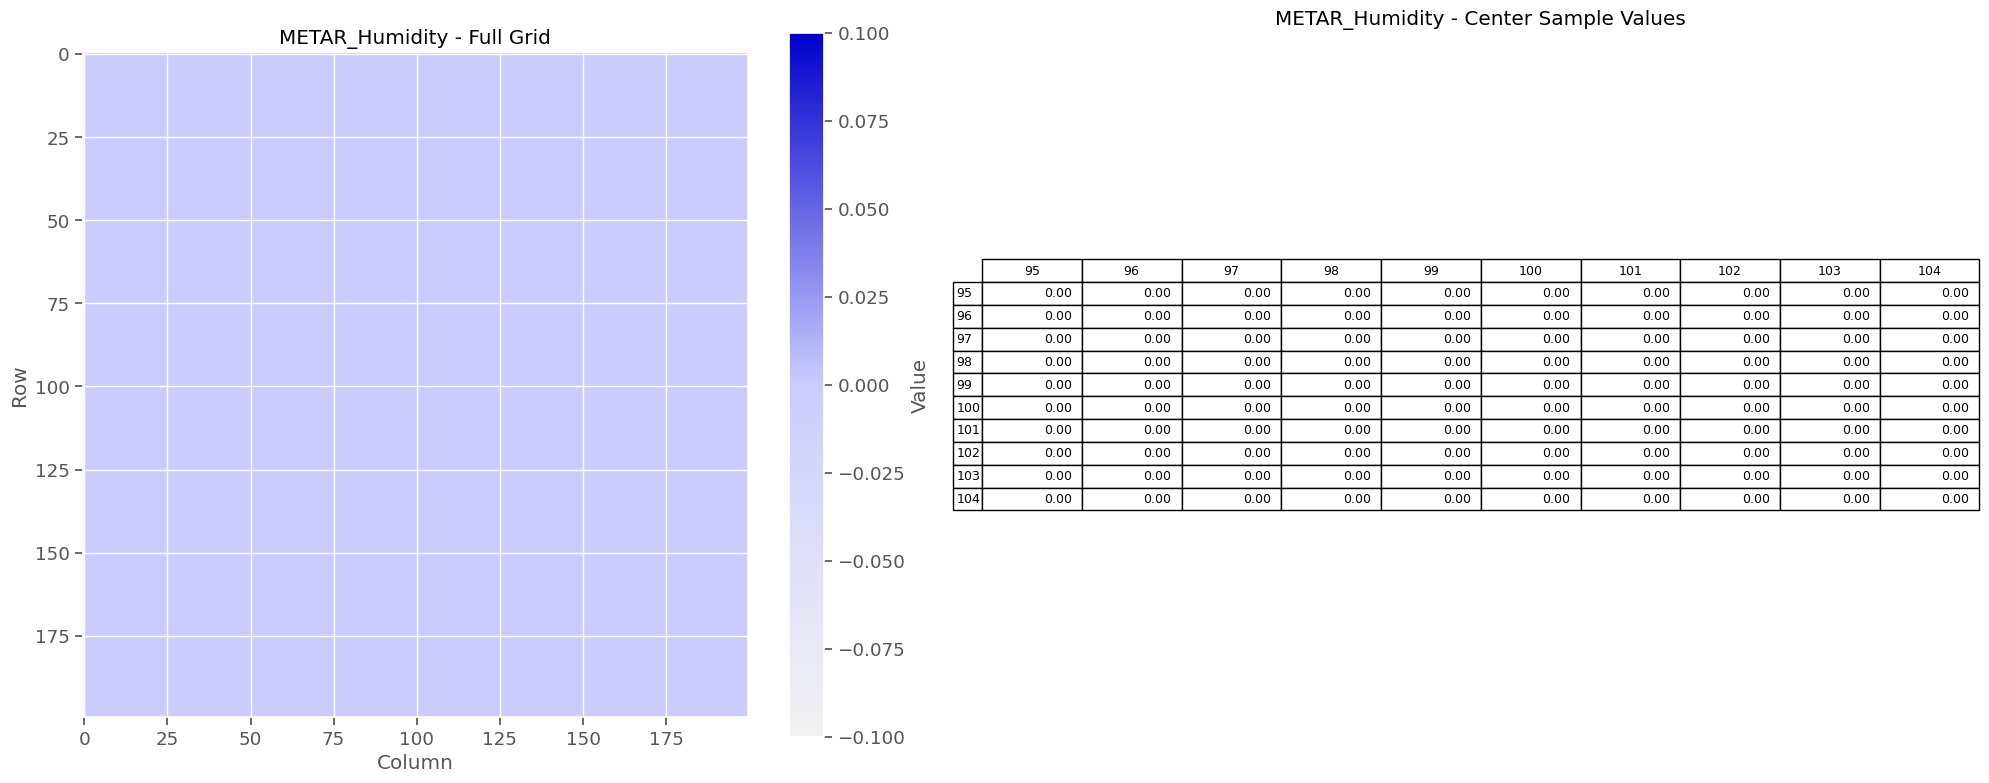


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 13: METAR_Heat_Index ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


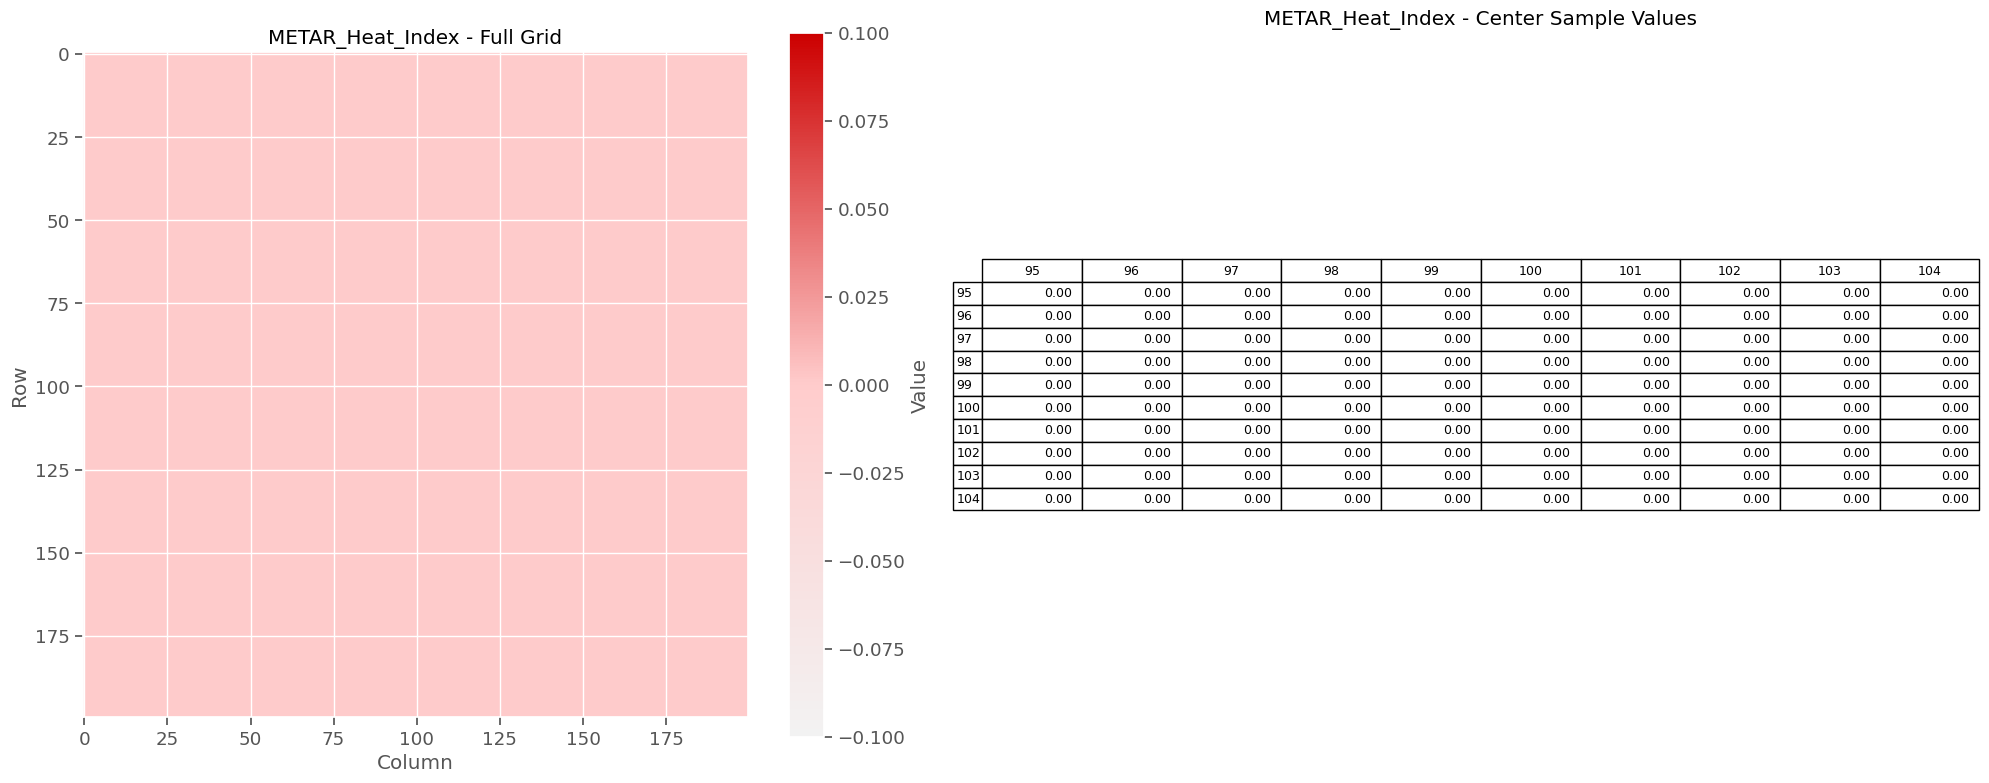


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 14: METAR_Air_Temp ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


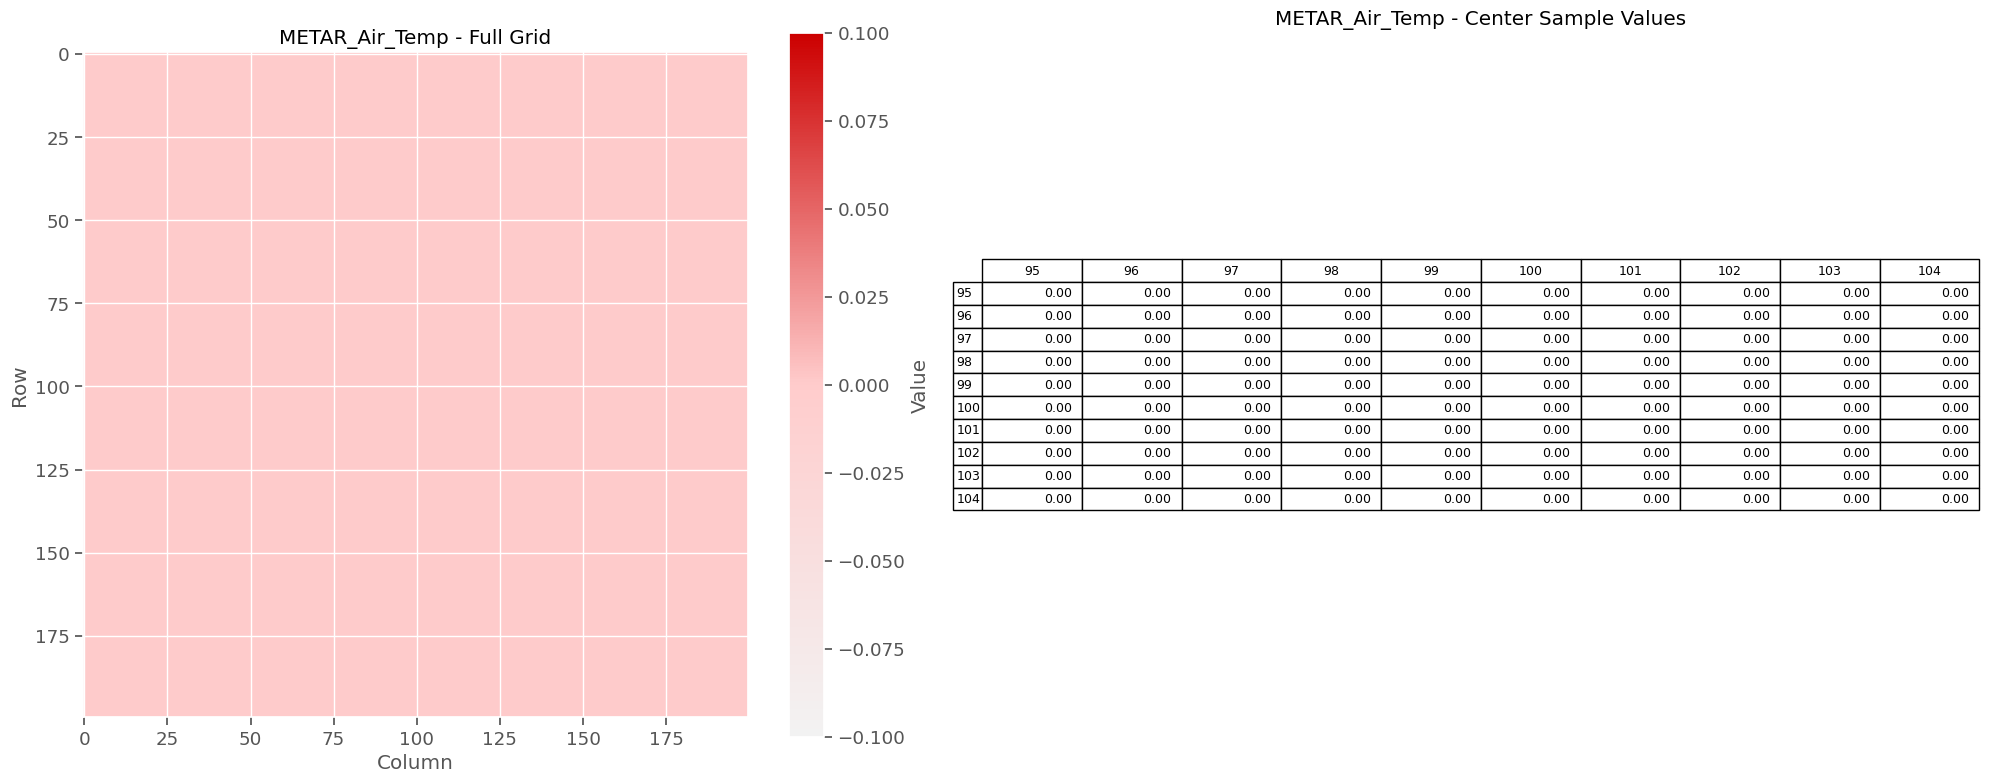


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 15: METAR_Air_Pressure ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


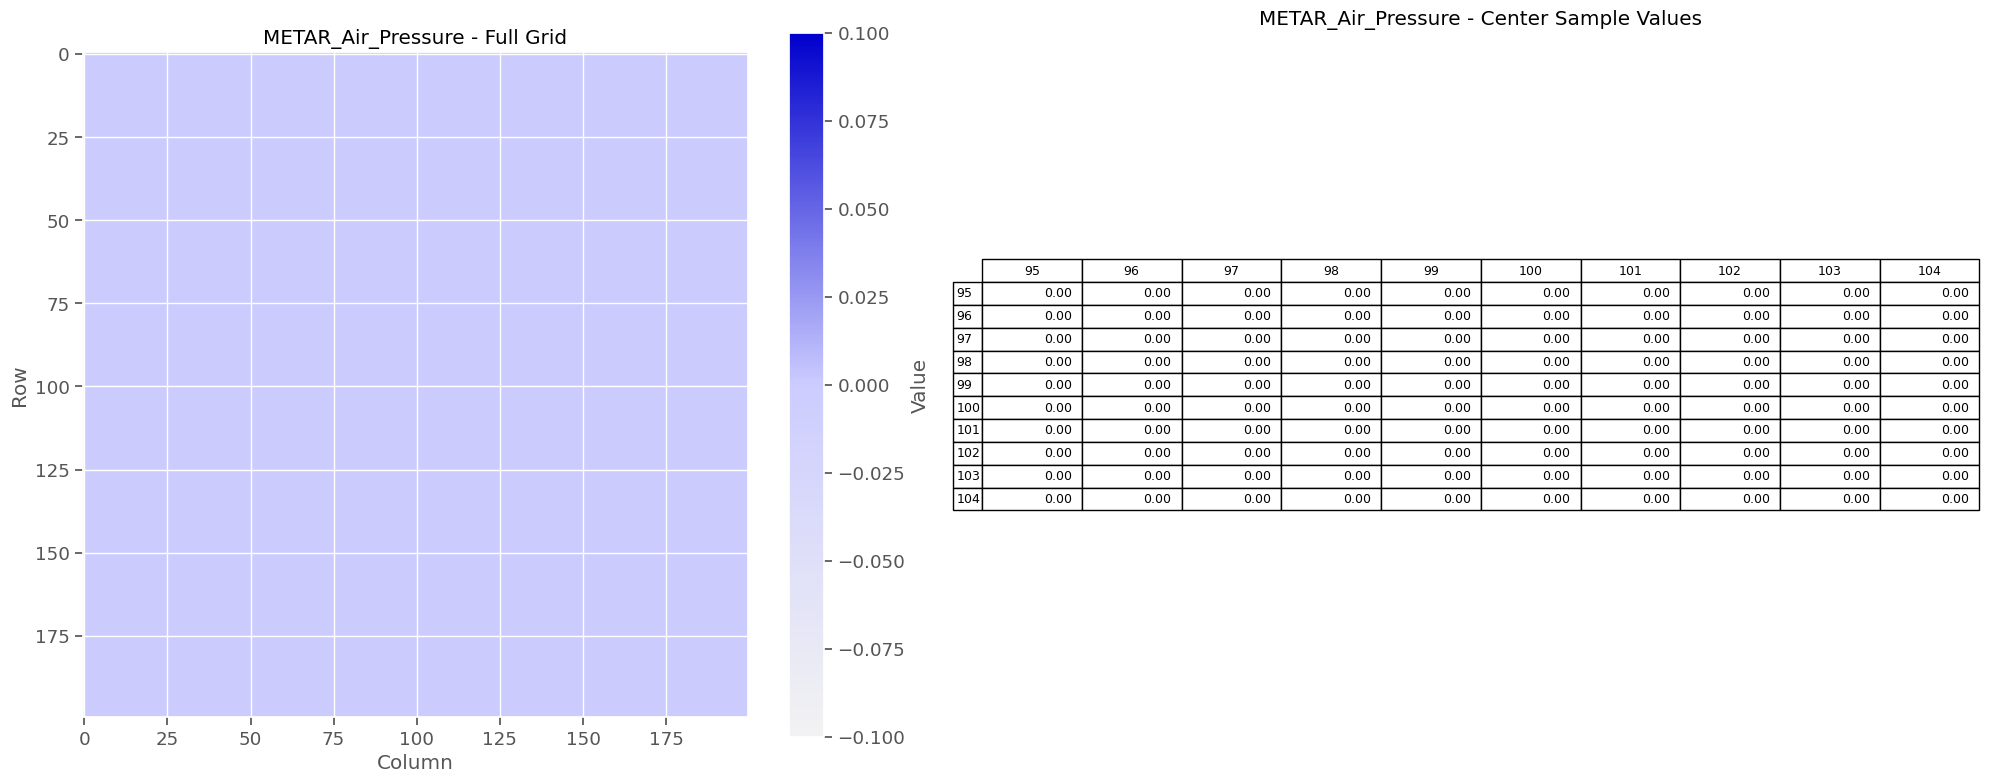


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Channel 16: METAR_Dew_Point ###
Min: 0.0000
Max: 0.0000
Mean: 0.0000
Std: 0.0000
Data coverage: 0.00% (0/40000 non-zero pixels)


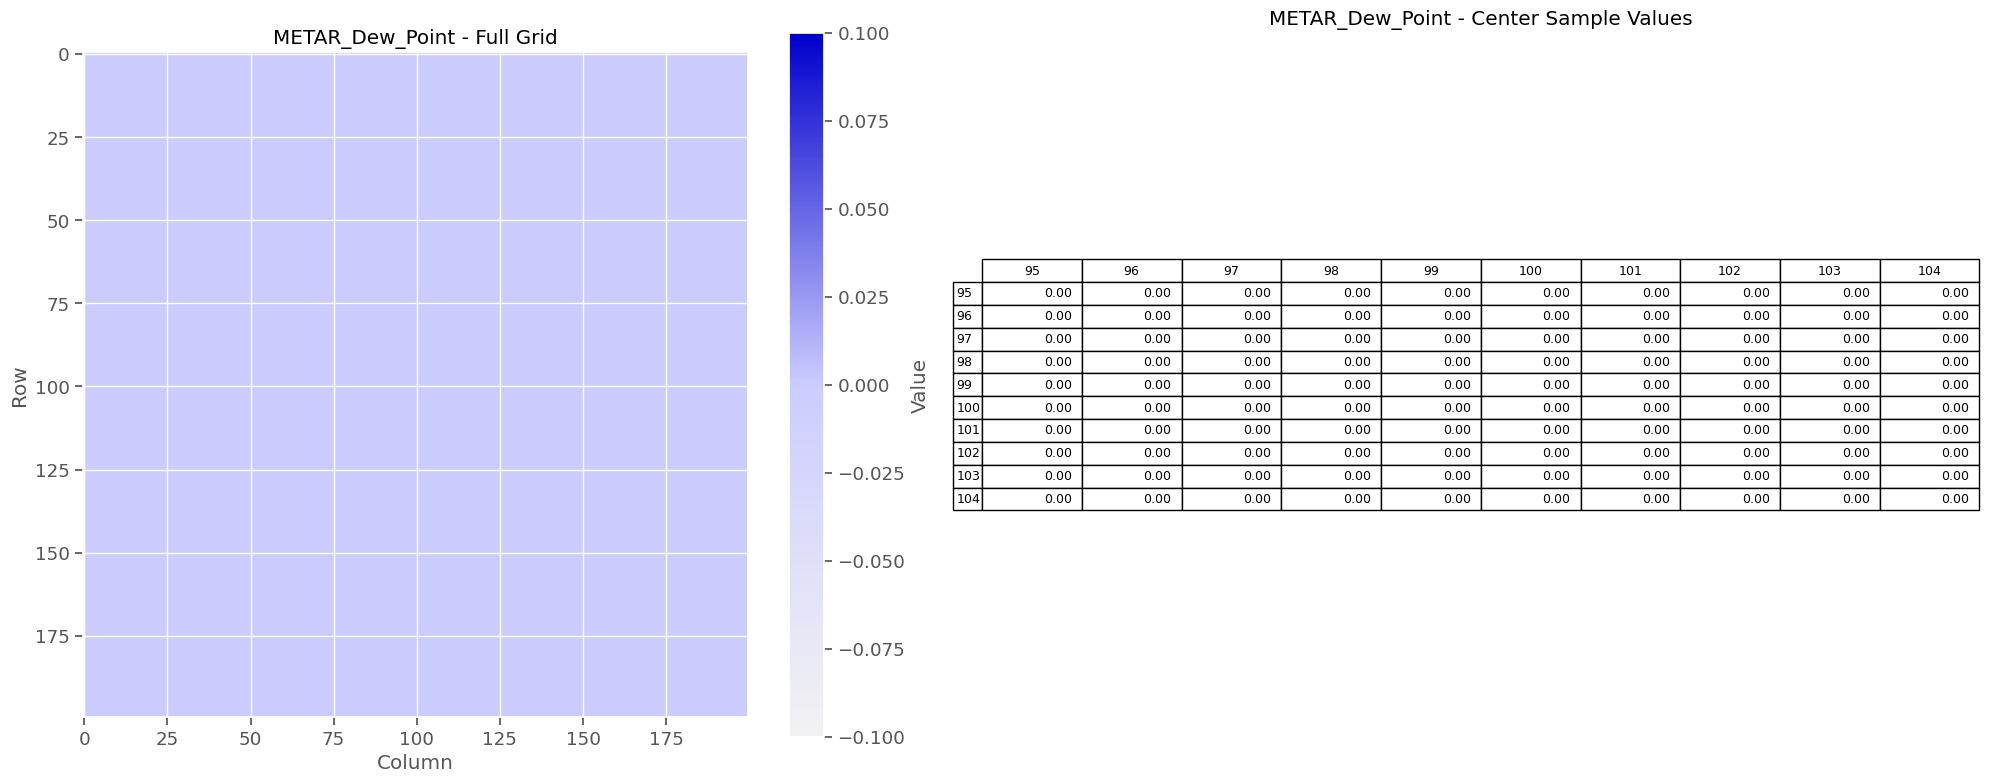


Center sample data:


Column,95,96,97,98,99,100,101,102,103,104
Row,,,,,,,,,,
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Get indices for METAR channels
metar_indices = [i for i, name in enumerate(channel_info['channel_names']) 
                if name in channel_info['metar_channels']]

# Analyze each METAR channel
for i, idx in enumerate(metar_indices):
    channel_name = channel_info['channel_names'][idx]
    
    # Use appropriate colormap based on channel content
    if any(term in channel_name for term in ['Temp', 'Heat']):
        cmap = cmap_red
    elif any(term in channel_name for term in ['AQI', 'Precipitation']):
        cmap = cmap_green
    else:
        cmap = cmap_blue
        
    df = analyze_channel(data, idx, channel_name, colormap=cmap)
    display(df)

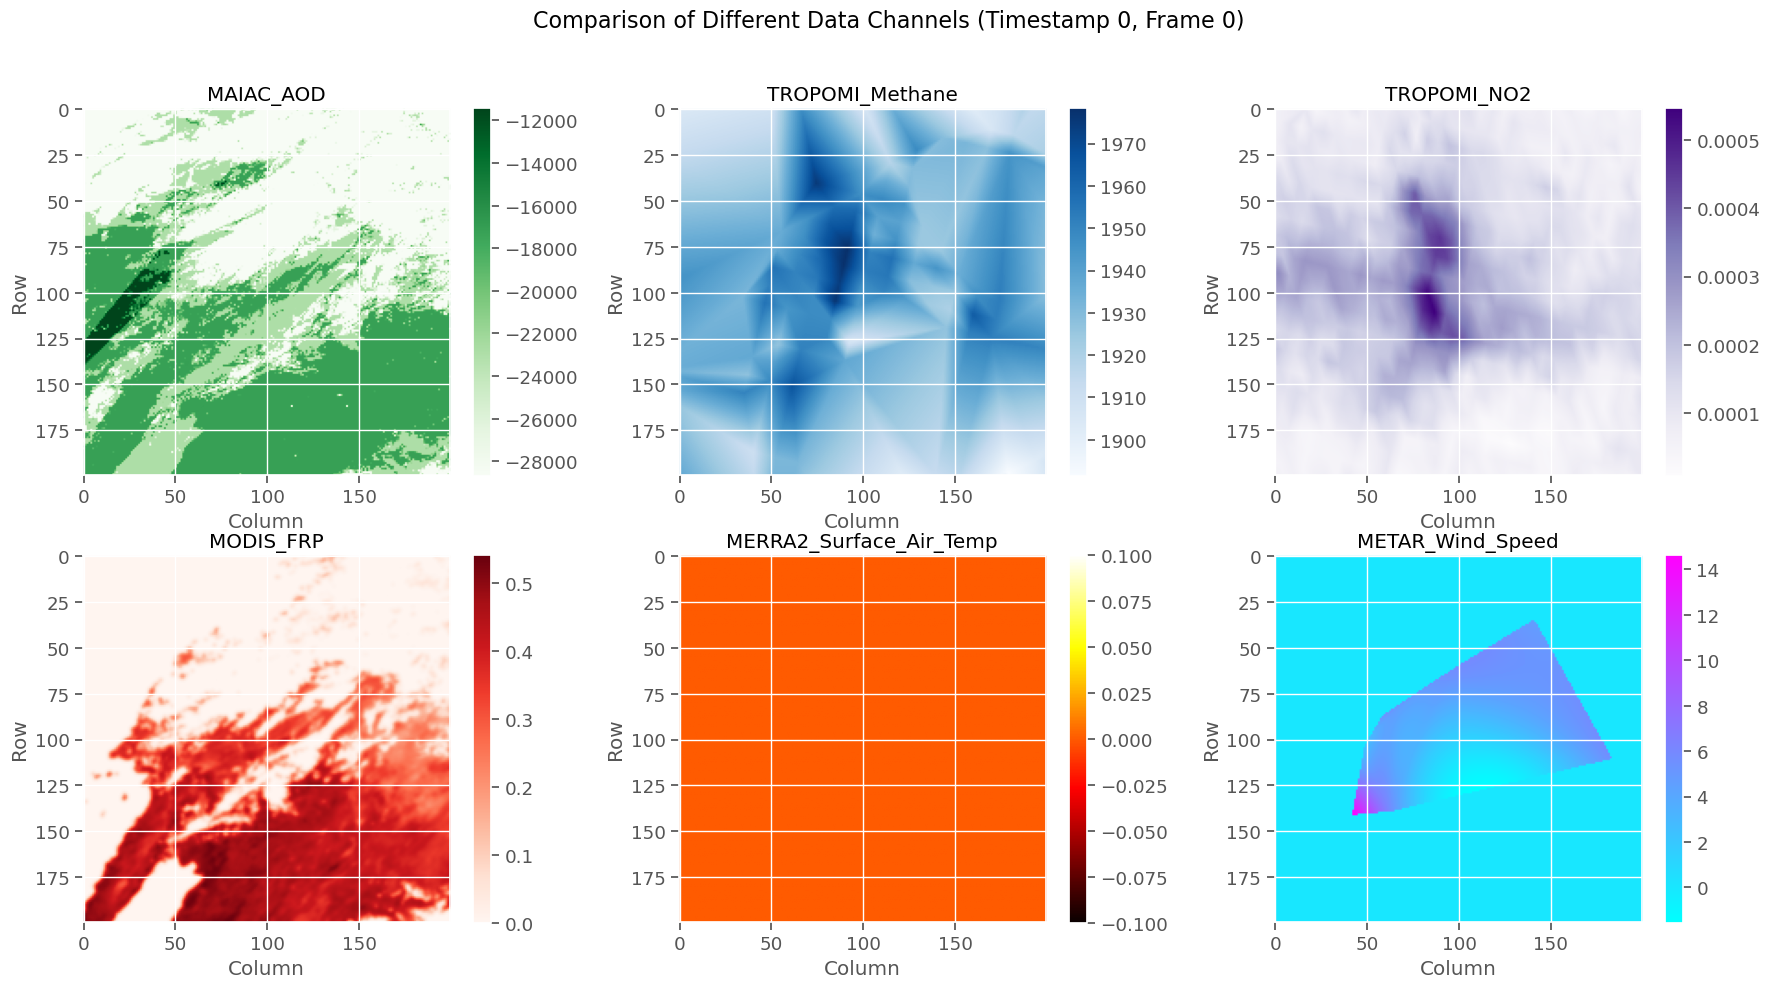

In [10]:
# Compare different data channels at the same timestamp/frame
timestamp_idx = 0
frame_idx = 0

# Get channel information
channel_info = data.get_channel_info()

# Select diverse channels to compare
channels_to_compare = [
    ('MAIAC_AOD', 0),                # Aerosol optical depth
    ('TROPOMI_Methane', 1),          # Methane concentration
    ('TROPOMI_NO2', 2),              # Nitrogen dioxide
    ('MODIS_FRP', 3),                # Fire radiative power
    ('MERRA2_Surface_Air_Temp', 5),  # Temperature
    ('METAR_Wind_Speed', 7)          # Wind speed
]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Select appropriate colormaps for different variables
cmaps = {
    'MAIAC_AOD': 'Greens',
    'TROPOMI_Methane': 'Blues', 
    'TROPOMI_NO2': 'Purples',
    'MODIS_FRP': 'Reds',
    'MERRA2_Surface_Air_Temp': 'hot',
    'METAR_Wind_Speed': 'cool'
}

# Plot each channel
for i, (channel_name, channel_offset) in enumerate(channels_to_compare):
    if i < len(axes):
        # Find the actual channel index
        channel_idx = channel_offset  # Default to offset
        for j, name in enumerate(channel_info['channel_names']):
            if name == channel_name:
                channel_idx = j
                break
        
        # Get data for this channel
        channel_data = data.data[timestamp_idx, frame_idx, :, :, channel_idx]
        
        # Display the data
        im = axes[i].imshow(channel_data, cmap=cmaps.get(channel_name, 'viridis'))
        axes[i].set_title(f"{channel_name}")
        axes[i].set_xlabel('Column')
        axes[i].set_ylabel('Row')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i])

plt.suptitle(f"Comparison of Different Data Channels (Timestamp {timestamp_idx}, Frame {frame_idx})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()